# Kaggle Advance Housing Project

this an end to end analysis of an introductory dataset on the Kaggle website. The target variable of this data set is the sale prices of the houses, and the other variables included in this data set ranges from the location of house to its basic structure and parts. 

the output of the prediction is evaluated by taking the rmse of the logarithm of the prices. I employed some basic feature engineering and Machine Learning technique in this notebook. my output resulted in an rmse iof 0.124, which is in the top quartile of the public leaderboard of kaggle.

for more information about this dataset, please visit https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

## Pre processing

First of all, I will import all the libraries that will be used in this notebook

In [1]:
library(plyr)
library(tidyverse) # metapackage with lots of helpful functions
library(caret)
library(rpart)
library("e1071")
library(randomForest)
library(objectStoreR)
library(ModelMetrics)
library(elasticnet)
library(glmnet)
library(xgboost)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
arrange():   dplyr, plyr
compact():   purrr, plyr
count():     dplyr, plyr
failwith():  dplyr, plyr
filter():    dplyr, stats
id():        dplyr, plyr
lag():       dplyr, stats
mutate():    dplyr, plyr
rename():    dplyr, plyr
summarise(): dplyr, plyr
summarize(): dplyr, plyr
Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin


Attaching package: 'ModelMetrics'

The following objects are masked from 'package:caret':

    confusionMatrix, preci

next I will be reading in both the training and testing data set. After so the logarithm of the Sale Prices column of the training data set would have to taken, in order for us to easily evaluate the model with the criterion used in the final assessment.

In [2]:
train <- read.csv("train.csv")
test <- read.csv("test.csv")
train$SalePrice <- log(train$SalePrice)

Before moving on directly to tidying up the data, I would first combine the data together. A variable set will be added to differentiate the training data and the testing data

In [3]:
test_mod <- test %>% mutate(SalePrice = NA) %>% mutate(set = "test")
train_mo <- train %>% mutate(set = "train")
com <- rbind(test_mod, train_mo)
com$set <- as.factor(com$set)
summary(com)
str(com)

       Id           MSSubClass        MSZoning     LotFrontage    
 Min.   :   1.0   Min.   : 20.00   C (all):  25   Min.   : 21.00  
 1st Qu.: 730.5   1st Qu.: 20.00   FV     : 139   1st Qu.: 59.00  
 Median :1460.0   Median : 50.00   RH     :  26   Median : 68.00  
 Mean   :1460.0   Mean   : 57.14   RL     :2265   Mean   : 69.31  
 3rd Qu.:2189.5   3rd Qu.: 70.00   RM     : 460   3rd Qu.: 80.00  
 Max.   :2919.0   Max.   :190.00   NA's   :   4   Max.   :313.00  
                                                  NA's   :486     
    LotArea        Street      Alley      LotShape   LandContour  Utilities   
 Min.   :  1300   Grvl:  12   Grvl: 120   IR1: 968   Bnk: 117    AllPub:2916  
 1st Qu.:  7478   Pave:2907   Pave:  78   IR2:  76   HLS: 120    NoSeWa:   1  
 Median :  9453               NA's:2721   IR3:  16   Low:  60    NA's  :   2  
 Mean   : 10168                           Reg:1859   Lvl:2622                 
 3rd Qu.: 11570                                                      

'data.frame':	2919 obs. of  82 variables:
 $ Id           : int  1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 ...
 $ MSSubClass   : int  20 20 60 60 120 60 20 60 20 20 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 3 4 4 4 4 4 4 4 4 4 ...
 $ LotFrontage  : int  80 81 74 78 43 75 NA 63 85 70 ...
 $ LotArea      : int  11622 14267 13830 9978 5005 10000 7980 8402 10176 8400 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 1 1 1 1 1 1 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 2 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 1 5 5 5 1 5 5 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 l

## data preparation

the first thing that I will do will be to clear out the variables with minimla variance. These variables are quite unecessary for the prediction that we'll do later on

In [4]:
train_mod <- as.data.frame(lapply(train_mo, as.numeric))
index <- nearZeroVar(train_mod)

Warning message in lapply(train_mo, as.numeric):
"NAs introduced by coercion"

However it may too presumptous to just remove all the variables with low variance, since some of it might offer valuable inside. Given that we will be using rpart as a descriptive tool to remain some of the important variables with low variance and remove those that don't seem to be important at all

In [5]:
index_mod <- c(index, 81)
tree <- rpart(SalePrice ~., data = train_mo[,index_mod], control = rpart.control(maxdepth = 30))
tree

n= 1460 

node), split, n, deviance, yval
      * denotes terminal node

  1) root 1460 232.8007000 12.02405  
    2) EnclosedPorch>=19.5 207  29.5940900 11.80953  
      4) EnclosedPorch< 144.5 103  11.3497800 11.70123 *
      5) EnclosedPorch>=144.5 104  15.8399300 11.91678 *
    3) EnclosedPorch< 19.5 1253 192.1066000 12.05949  
      6) Heating=Floor,Grav,Wall 9   0.9751947 11.20270 *
      7) Heating=GasA,GasW 1244 184.4767000 12.06569  
       14) KitchenAbvGr>=1.5 51   2.9203760 11.75720 *
       15) KitchenAbvGr< 1.5 1193 176.4954000 12.07888  
         30) BsmtCond=Fa,Po 25   2.7302120 11.61750 *
         31) BsmtCond=Gd,TA 1168 168.3296000 12.08875  
           62) RoofMatl=ClyTile,CompShg,Metal,Tar&Grv,WdShake 1161 164.1600000 12.08500  
            124) GarageQual=Ex,Fa 24   2.3609250 11.76050 *
            125) GarageQual=Gd,TA 1137 159.2185000 12.09185  
              250) Functional=Maj1,Maj2,Min1,Min2,Sev 57   4.5552470 11.89741 *
              251) Functional=Mod,Typ 1

from the above decision 6 variables including whether or not the Porch is Enclosed to the Roof Material seem to have valuable insight thus those will remain in the data set

In [6]:
remove <- c(which(colnames(train)=="EnclosedPorch"), 
                  which(colnames(train)=="RoofMatl"), 
                        which(colnames(train)=="KitchenAbvGr"), 
                              which(colnames(train)=="BsmtCond"), 
                              which(colnames(train)=="LandContour"),
                               which(colnames(com)=="set"))
index_fin <- index[!index %in% remove]
com_fin <- com[, -index_fin]

now I shall take a look at the missing value in this data

In [7]:
missing_values <- com_fin %>% summarize_all(funs(sum(is.na(.))))
missing_values <- gather(missing_values, key="feature", value="missing")
missing_values %>% filter(missing != 0)

feature,missing
MSZoning,4
LotFrontage,486
Alley,2721
Exterior1st,1
Exterior2nd,1
MasVnrType,24
MasVnrArea,23
BsmtQual,81
BsmtCond,82
BsmtExposure,82


There seem to be quite an amount of missing values that would have to be handled, however upon further investigation a lot of the variables have NA values that simply represents the lack of a feature. For these variable, I would simply rename them so the models later could procede normally.

In [8]:
Name <- as.vector(levels(com_fin$Alley))
com_fin$Alley <- as.character(com_fin$Alley)
com_fin$Alley[is.na(com_fin$Alley)] <- "No_alley_access"
com_fin$Alley <- as.factor(com_fin$Alley)

In [9]:
com_fin$FireplaceQu <- as.character(com_fin$FireplaceQu)
com_fin$FireplaceQu[is.na(com_fin$FireplaceQu)] <- "No_fireplace"
com_fin$FireplaceQu <- as.factor(com_fin$FireplaceQu)

In [10]:
com_fin$PoolQC <- as.character(com_fin$PoolQC)
com_fin$PoolQC[is.na(com_fin$PoolQC)] <- "No_pool"
com_fin$PoolQC <- as.factor(com_fin$PoolQC)

In [11]:
com_fin$Fence <- as.character(com_fin$Fence)
com_fin$Fence[is.na(com_fin$Fence)] <- "No_fence"
com_fin$Fence <- as.factor(com_fin$Fence)

In [12]:
com_fin$GarageType <- as.character(com_fin$GarageType)
com_fin$GarageType[is.na(com_fin$GarageType)] <- "No_Garage"
com_fin$GarageType <- as.factor(com_fin$GarageType)
com_fin$GarageYrBlt <- as.character(com_fin$GarageYrBlt)
com_fin$GarageYrBlt[is.na(com_fin$GarageYrBlt)] <- "No_Garage"
com_fin$GarageYrBlt <- as.factor(com_fin$GarageYrBlt)
com_fin$GarageFinish <- as.character(com_fin$GarageFinish)
com_fin$GarageFinish[is.na(com_fin$GarageFinish)] <- "No_Garage"
com_fin$GarageFinish <- as.factor(com_fin$GarageFinish)

In [13]:
com_fin$BsmtQual <- as.character(com_fin$BsmtQual)
com_fin$BsmtQual[is.na(com_fin$BsmtQual)] <- "No_Basement"
com_fin$BsmtQual <- as.factor(com_fin$BsmtQual)
com_fin$BsmtCond <- as.character(com_fin$BsmtCond)
com_fin$BsmtCond[is.na(com_fin$BsmtCond)] <- "No_Basement"
com_fin$BsmtCond <- as.factor(com_fin$BsmtCond)
com_fin$BsmtExposure <- as.character(com_fin$BsmtExposure)
com_fin$BsmtExposure[is.na(com_fin$BsmtExposure)] <- "No_Basement"
com_fin$BsmtExposure <- as.factor(com_fin$BsmtExposure)
com_fin$BsmtFinType1 <- as.character(com_fin$BsmtFinType1)
com_fin$BsmtFinType1[is.na(com_fin$BsmtFinType1)] <- "No_Basement"
com_fin$BsmtFinType1 <- as.factor(com_fin$BsmtFinType1)

In [14]:
com_fin$Electrical <- as.character(com_fin$Electrical)
com_fin$Electrical[is.na(com_fin$Electrical)] <- "SBrKr"
com_fin$Electrical <- as.factor(com_fin$Electrical)

For the other variables that are NA most likely because of the lack of data, I will simply run some predict modelling to impute those values.

In [15]:
tree_MSz <- rpart(MSZoning ~LotArea + Neighborhood, com_fin[!is.na(com_fin$MSZoning),], method="class")
com_fin$MSZoning[is.na(com_fin$MSZoning)] <- predict(tree_MSz, com_fin[is.na(com_fin$MSZoning),], type = "class")

In [16]:
tree_LF <- lm(LotFrontage ~LotArea + Neighborhood + BldgType + LotConfig, com_fin[!is.na(com_fin$LotFrontage),])
com_fin$LotFrontage[is.na(com_fin$LotFrontage)] <- predict(tree_LF, com_fin[is.na(com_fin$LotFrontage),])

In [17]:
tree_Ex1 <- rpart(Exterior1st ~Exterior2nd, com_fin[!is.na(com_fin$Exterior1st),], method="class")
com_fin$Exterior1st[is.na(com_fin$Exterior1st)] <- predict(tree_Ex1, com_fin[is.na(com_fin$Exterior1st),], type = "class")

In [18]:
tree_Ex2 <- rpart(Exterior2nd ~ Exterior1st, com_fin[!is.na(com_fin$Exterior2nd),], method="class")
com_fin$Exterior2nd[is.na(com_fin$Exterior2nd)] <- predict(tree_Ex2, com_fin[is.na(com_fin$Exterior2nd),], type = "class")

In [19]:
tree_Mt <- rpart(MasVnrType ~ MasVnrArea, com_fin[!is.na(com_fin$MasVnrType),], method="class")
com_fin$MasVnrType[is.na(com_fin$MasVnrType)] <- predict(tree_Mt, com_fin[is.na(com_fin$MasVnrType),], type = "class")

In [20]:
tree_Ma <- rpart(MasVnrArea ~ MasVnrType, com_fin[!is.na(com_fin$MasVnrArea),], method="class")
com_fin$MasVnrArea[is.na(com_fin$MasVnrArea)] <- predict(tree_Ma, com_fin[is.na(com_fin$MasVnrArea),], type = "class")

In [21]:
mod_fb <- rpart(BsmtFullBath ~BsmtFinSF1 + BsmtHalfBath + BsmtUnfSF + X2ndFlrSF + BldgType + BsmtFinType1, 
                com_fin[!is.na(com_fin$BsmtFullBath),], method="anova")
com_fin$BsmtFullBath[is.na(com_fin$BsmtFullBath)] <- round(predict(mod_fb, com_fin[is.na(com_fin$BsmtFullBath),]))

In [22]:
mod_hb <- rpart(BsmtHalfBath ~BsmtFinSF1 + BsmtFullBath + BsmtUnfSF + X2ndFlrSF + BldgType + BsmtFinType1, 
                com_fin[!is.na(com_fin$BsmtHalfBath),], method="anova")
com_fin$BsmtHalfBath[is.na(com_fin$BsmtHalfBath)] <- round(predict(mod_hb, com_fin[is.na(com_fin$BsmtHalfBath),]))

In [23]:
mod_hb <- rpart(BsmtFinSF1 ~ BsmtFinType1 + TotalBsmtSF + BsmtUnfSF + GarageYrBlt, com_fin[!is.na(com_fin$BsmtFinSF1),], method="anova")
com_fin$BsmtFinSF1[is.na(com_fin$BsmtFinSF1)] <- predict(mod_hb, com_fin[is.na(com_fin$BsmtFinSF1),])

In [24]:
mod_us <- rpart(BsmtUnfSF ~ BsmtFinType1 + TotalBsmtSF + GarageYrBlt, com_fin[!is.na(com_fin$BsmtUnfSF),], method="anova")
com_fin$BsmtUnfSF[is.na(com_fin$BsmtUnfSF)] <- predict(mod_us, com_fin[is.na(com_fin$BsmtUnfSF),])

In [25]:
mod_tbs <- rpart(TotalBsmtSF ~ X1stFlrSF + BsmtQual + GarageYrBlt + BsmtFinSF1, com_fin[!is.na(com_fin$TotalBsmtSF),], method="anova")
com_fin$TotalBsmtSF[is.na(com_fin$TotalBsmtSF)] <- predict(mod_tbs, com_fin[is.na(com_fin$TotalBsmtSF),])

In [26]:
tree_kq <- rpart(KitchenQual ~ ExterQual + OverallQual, com_fin[!is.na(com_fin$KitchenQual),], method="class")
com_fin$KitchenQual[is.na(com_fin$KitchenQual)] <- predict(tree_kq, com_fin[is.na(com_fin$KitchenQual),], type = "class")

In [27]:
mod_gc <- rpart(GarageCars ~ ., com_fin[!is.na(com_fin$GarageCars),], method="anova")
com_fin$GarageCars[is.na(com_fin$GarageCars)] <- predict(mod_gc, com_fin[is.na(com_fin$GarageCars),])

In [28]:
mod_ga <- rpart(GarageArea ~ ., com_fin[!is.na(com_fin$GarageArea),], method="anova")
com_fin$GarageArea[is.na(com_fin$GarageArea)] <- predict(mod_ga, com_fin[is.na(com_fin$GarageArea),])

In [29]:
tree_st <- rpart(SaleType ~ SaleCondition, com_fin[!is.na(com_fin$SaleType),], method="class")
com_fin$SaleType[is.na(com_fin$SaleType)] <- predict(tree_st, com_fin[is.na(com_fin$SaleType),], type = "class")

now as we recheck the missing value again, the only missing value should be the Sale Price in the testing set

In [30]:
missing_values <- com_fin %>% summarize_all(funs(sum(is.na(.))))
missing_values <- gather(missing_values, key="feature", value="missing")
missing_values %>% filter(missing != 0)

feature,missing
SalePrice,1459


## Explanatory Data Analysis + Feature Engineering

Now we will look into the data one by one and perform some feature engineering when deemed necessary. The first set of variables we will look at are the overall quality and living area. Particularly we will look at their relationship with Sale Price. 

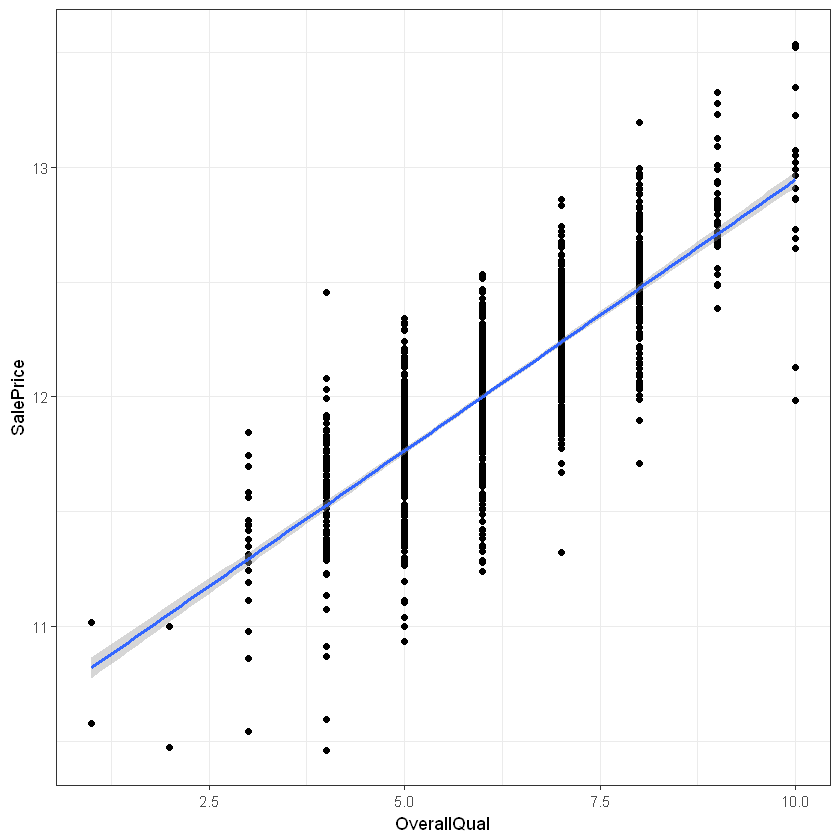

In [31]:
ggplot(com_fin[com_fin$set == "train",], aes(x = OverallQual, y = SalePrice)) + geom_point() + geom_smooth(method = "lm") + theme_bw()

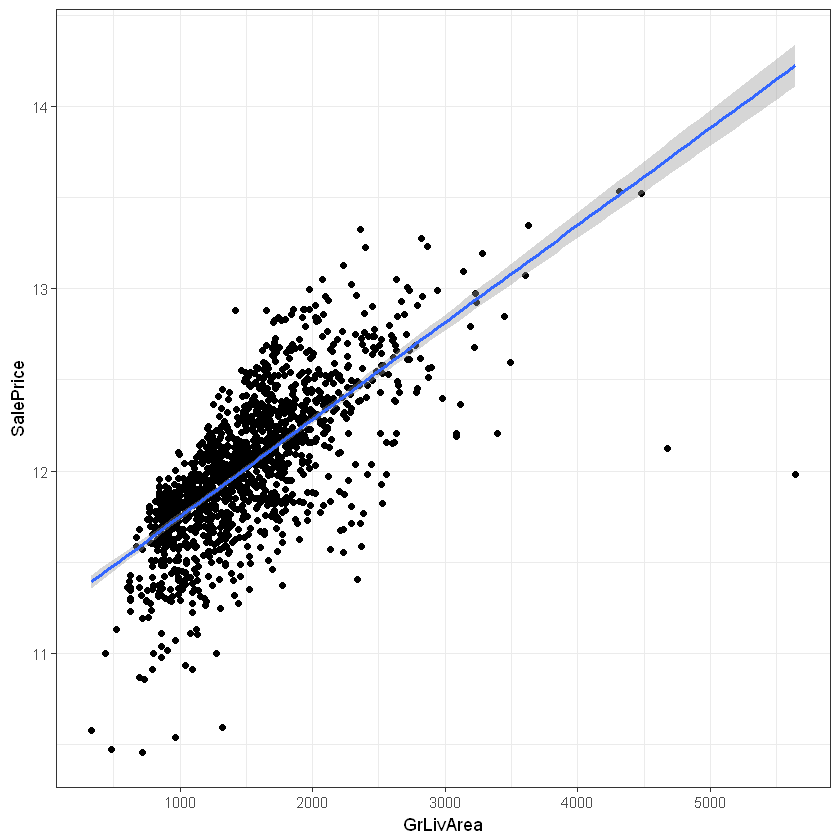

In [32]:
ggplot(com_fin[com_fin$set == "train",], aes(x = GrLivArea, y = SalePrice)) + geom_point() + geom_smooth(method = "lm") + theme_bw()

Both these variables seems highly correlated with the Sales Price and will probably be extremely useful for the predictive algorithm later. However there seem to be an outlier among the values in the Living Area which needs to be handled. 

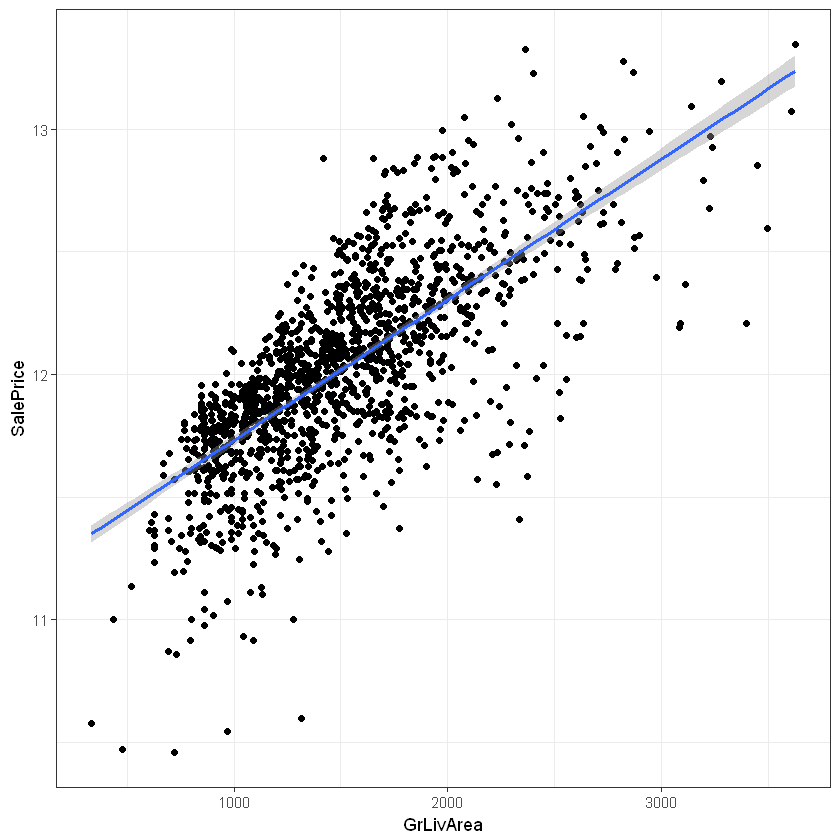

In [33]:
com_fin = com_fin %>% filter(!(set == "train" & GrLivArea > 4000))
ggplot(com_fin[com_fin$set == "train",], aes(x = GrLivArea, y = SalePrice)) + geom_point() + geom_smooth(method = "lm")+ theme_bw()

Now that looks better. Next we will look at the variable Neighborhood

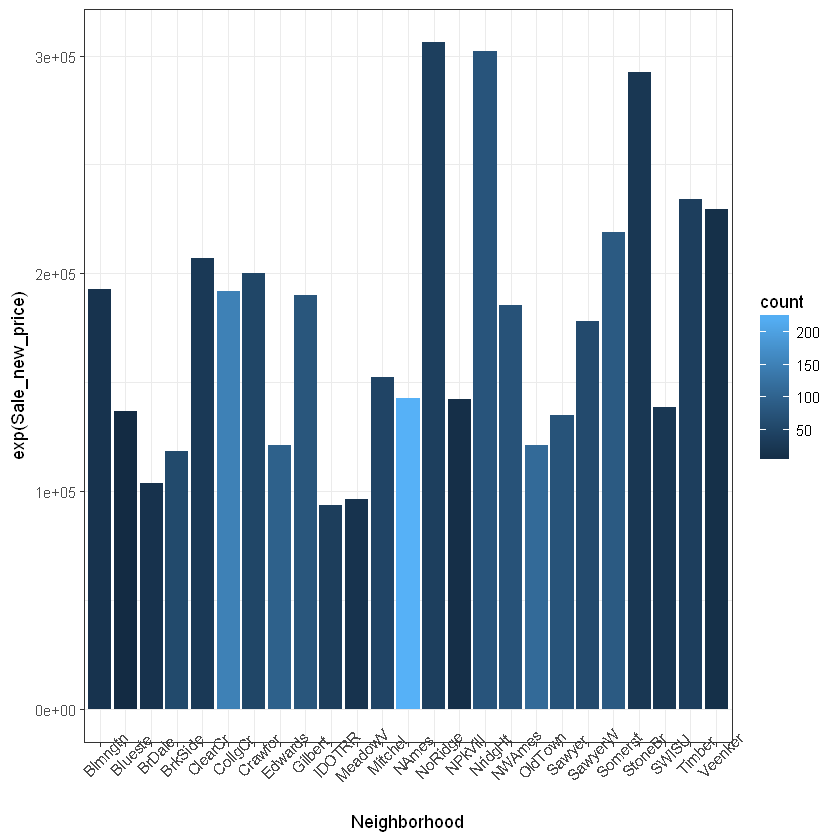

In [34]:
train_nb <- com_fin[com_fin$set == "train",] %>% group_by(Neighborhood)  %>% summarize(Sale_new_price = mean(SalePrice), count = n())
ggplot(train_nb, aes(x = Neighborhood, y = exp(Sale_new_price), fill = count)) + geom_col() + theme_bw() + theme(axis.text.x = element_text(angle = 45))

There seem to be quite a divide between the prices in the different Neighborhood, so to make the prediction later easier, let's manually divide up the classes of neighborhood and simplify the feature.

In [35]:
High_end_names <- unlist(unclass(train_nb %>% filter(Sale_new_price > log(3e+05)) %>% select(Neighborhood)))
Mid_end_names <- unlist(unclass(train_nb %>% filter(Sale_new_price < log(3e+05) & Sale_new_price > log(1.8e+05)) %>% select(Neighborhood)))
Mid_low_names <- unlist(unclass(train_nb %>% filter(Sale_new_price < log(1.8e+05) & Sale_new_price > log(1.2e+05)) %>% select(Neighborhood)))
low_end_names <- unlist(unclass(train_nb %>% filter(Sale_new_price < log(1.2e+05)) %>% select(Neighborhood)))

In [36]:
com_fin <- com_fin %>% mutate(Neighborhood_type = case_when(Neighborhood %in% High_end_names ~ "high",
                                                Neighborhood %in% Mid_end_names ~ "mid",
                                                Neighborhood %in% Mid_low_names ~ "mid_low",
                                                Neighborhood %in% low_end_names ~ "low"))
com_fin$GarageYrBlt <- as.numeric(com_fin$GarageYrBlt)
com_fin$Neighborhood_type <- as.factor(com_fin$Neighborhood_type)

Onto the next variable, the Sub Classes.

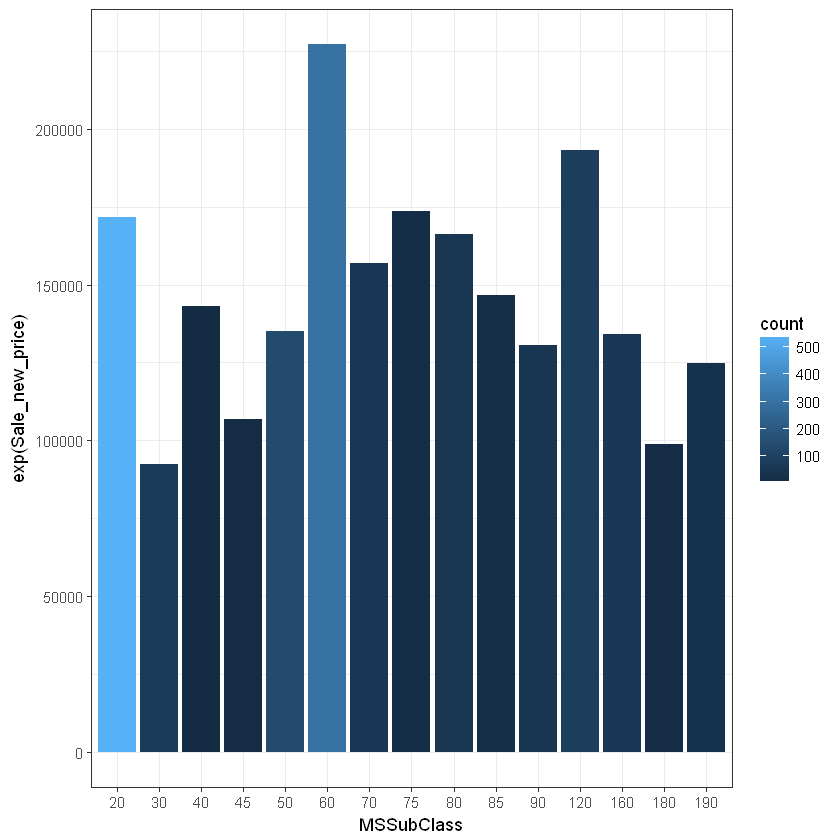

In [37]:
com_fin$MSSubClass <- as.factor(com_fin$MSSubClass)
train_mc <- com_fin[com_fin$set == "train",] %>% group_by(MSSubClass)  %>% summarize(Sale_new_price = mean(SalePrice), count = n())
ggplot(train_mc, aes(x = MSSubClass, y = exp(Sale_new_price), fill = count)) + geom_col() + theme_bw()

A divide is quite evident among the subclasses again, so lets repeat the process done for the Neighborhood on this feature.

In [38]:
High_end_class <- unlist(unclass(train_mc %>% filter(Sale_new_price > log(225000)) %>% select(MSSubClass)))
Mid_end_class <- unlist(unclass(train_mc %>% filter(Sale_new_price <= log(225000) & Sale_new_price > log(175000)) %>% select(MSSubClass)))
Mid_low_class <- unlist(unclass(train_mc %>% filter(Sale_new_price <= log(175000) & Sale_new_price > log(125000)) %>% select(MSSubClass)))
low_end_class <- unlist(unclass(train_mc %>% filter(Sale_new_price <= log(125000)) %>% select(MSSubClass)))

In [39]:
com_fin <- com_fin %>% mutate(SubClass_type = case_when(MSSubClass %in% High_end_class ~ "high",
                                                MSSubClass %in% Mid_end_class ~ "mid",
                                                MSSubClass %in% Mid_low_class ~ "mid_low",
                                                MSSubClass %in% low_end_class ~ "low"))
com_fin$SubClass_type <- as.factor(com_fin$SubClass_type)

The next feature to investigate on is the Year in which the house is built

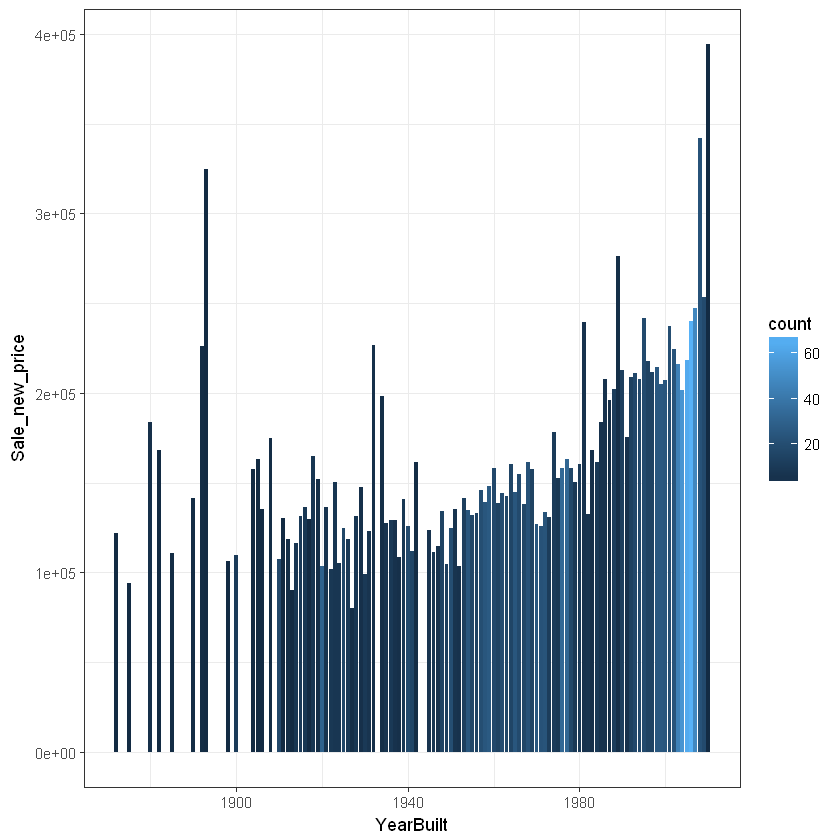

In [40]:
train_yb <- com_fin[com_fin$set == "train",] %>% group_by(YearBuilt)  %>% summarize(Sale_new_price = exp(mean(SalePrice)), count = n())
ggplot(train_yb, aes(x = YearBuilt, y = Sale_new_price, fill = count)) + geom_col() + theme_bw()

There are some obvious outliers among the older houses, which may dsirupt the prediction accuracy heavily, in the interest of that, I will transform the Year Built variable into Year groups and take the avearage out of the year groups as their value.

In [41]:
com_fin <- com_fin %>% mutate(Age = case_when(YearBuilt >= 2008 ~ "new",
                                                YearBuilt < 2008 & YearBuilt >= 1990 ~ "mid",
                                                YearBuilt < 1990 ~ "old"))
com_fin$Age <- as.factor(com_fin$Age)

Another feature that is interesting to look at is the Fireplace variable

FireplaceQu,Sale_new_price,count
Ex,12.63243,23
Fa,12.00851,33
Gd,12.25760,378
No_fireplace,11.80891,690
Po,11.73882,20
TA,12.18214,312


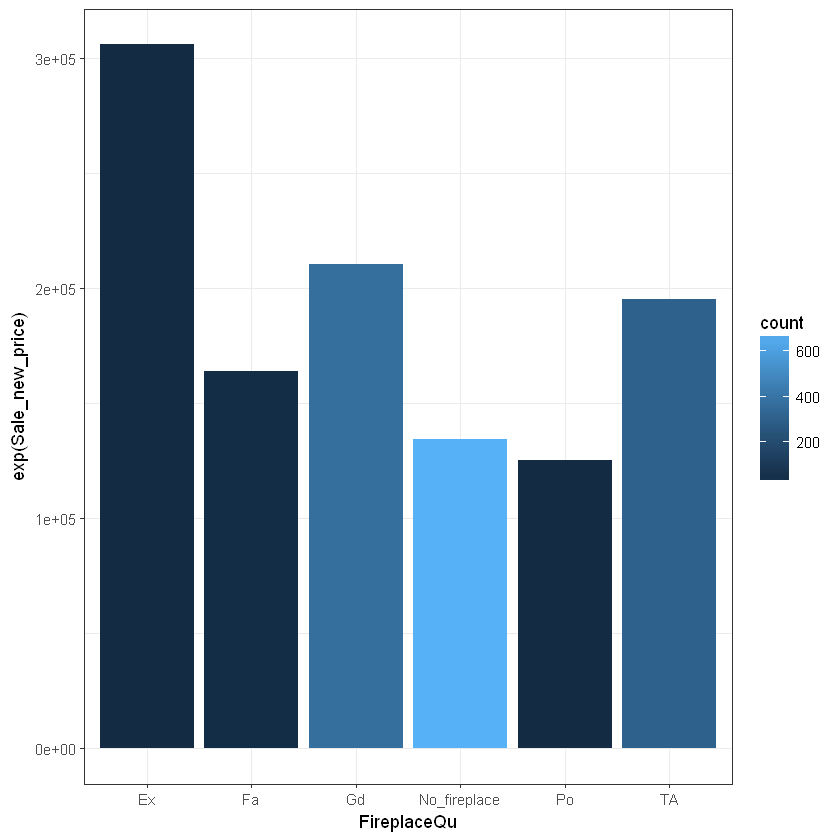

In [42]:
train_fq <- com_fin[com_fin$set == "train",] %>% group_by(FireplaceQu)  %>% summarize(Sale_new_price = mean(SalePrice), count = n())
train_fq
ggplot(train_fq, aes(x = FireplaceQu, y = exp(Sale_new_price), fill = count)) + geom_col() + theme_bw()

And let's deal with the divide again!

In [43]:
High_end_fire <- unlist(unclass(train_fq %>% filter(Sale_new_price > log(3e+05)) %>% select(FireplaceQu)))
Mid_end_fire <- unlist(unclass(train_fq %>% filter(Sale_new_price < log(3e+05) & Sale_new_price > log(2e+05)) %>% select(FireplaceQu)))
low_end_fire <- unlist(unclass(train_fq %>% filter(Sale_new_price < log(2e+05)) %>% select(FireplaceQu)))
com_fin <- com_fin %>% mutate(fire_type = case_when(FireplaceQu %in% High_end_fire ~ "high",
                                                FireplaceQu %in% Mid_end_fire ~ "mid",
                                                FireplaceQu %in% low_end_fire ~ "low"))
com_fin$fire_type <- as.factor(com_fin$fire_type)

Next I will look at two more area variables: the first and second floor area.

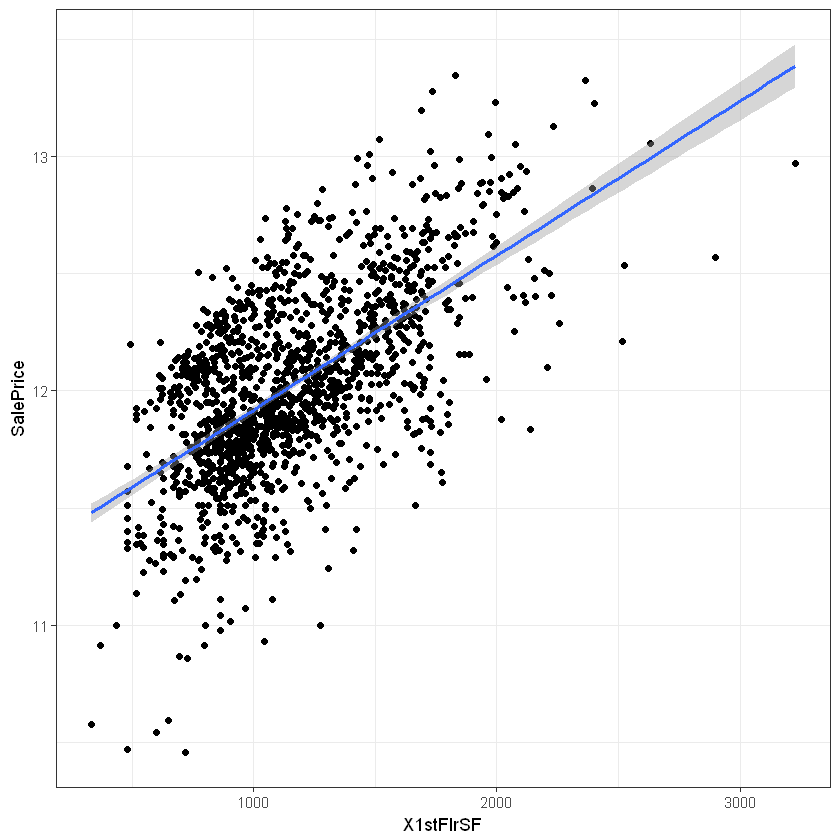

In [44]:
ggplot(com_fin[com_fin$set == "train",], aes(x = X1stFlrSF, y = SalePrice)) + geom_point() + geom_smooth(method = "lm") + theme_bw()

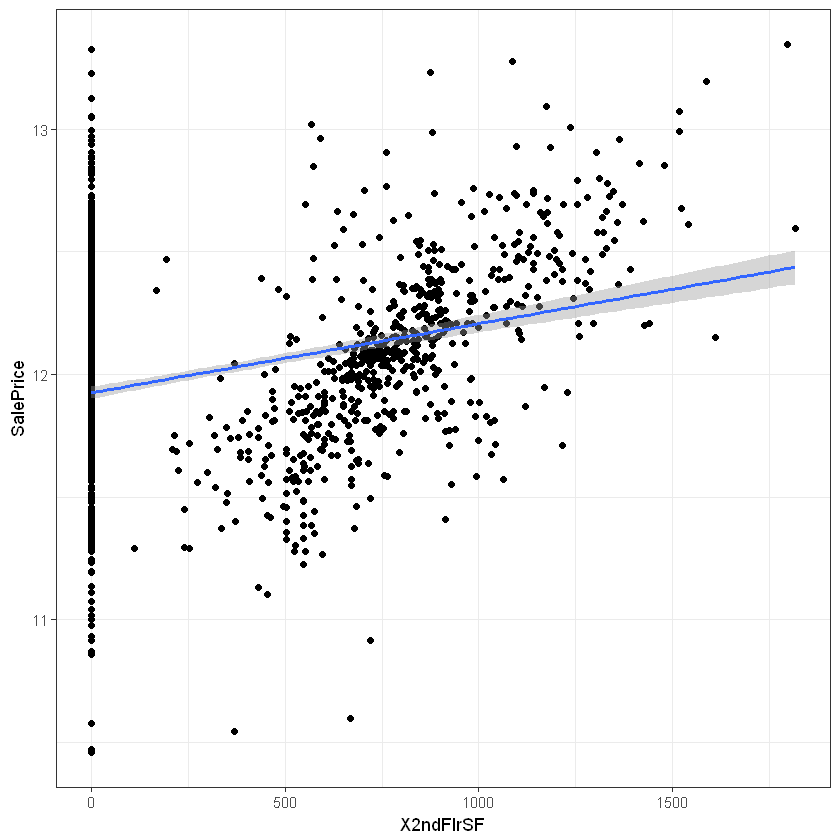

In [45]:
ggplot(com_fin[com_fin$set == "train",], aes(x = X2ndFlrSF, y = SalePrice)) + geom_point() + geom_smooth(method = "lm") + theme_bw()

The first floor size show quite a strong correlation with the Sale Price while the second floor size is less predictive due to the fact that some houses are missing a second floor. Given that it may be of interest to us to combine the first and second floor area

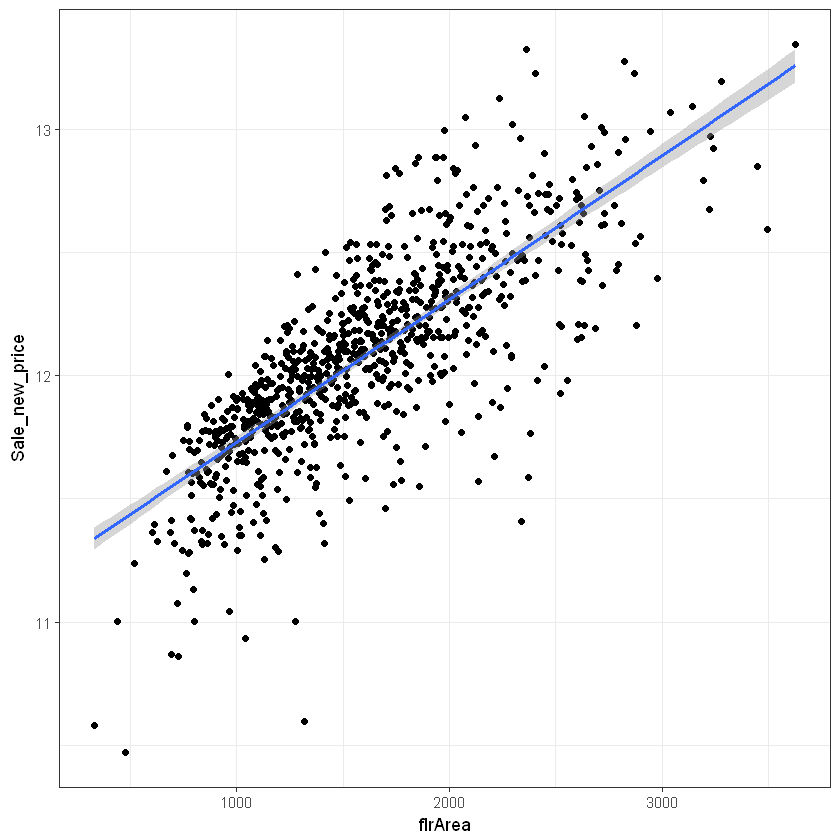

In [46]:
com_fin <- com_fin %>% mutate(flrArea = X1stFlrSF + X2ndFlrSF)
train_fr <- com_fin[com_fin$set == "train",] %>% group_by(flrArea)  %>% summarize(Sale_new_price = mean(SalePrice), count = n())
ggplot(train_fr, aes(x = flrArea, y = Sale_new_price)) + geom_point() + geom_smooth(method = "lm") + theme_bw()

This sure looks better! and now I will proceed to the Zoning variable

MSZoning,Sale_new_price,count
C (all),11.11826,10
FV,12.24662,65
RH,11.74984,16
RL,12.08342,1147
RM,11.69289,218


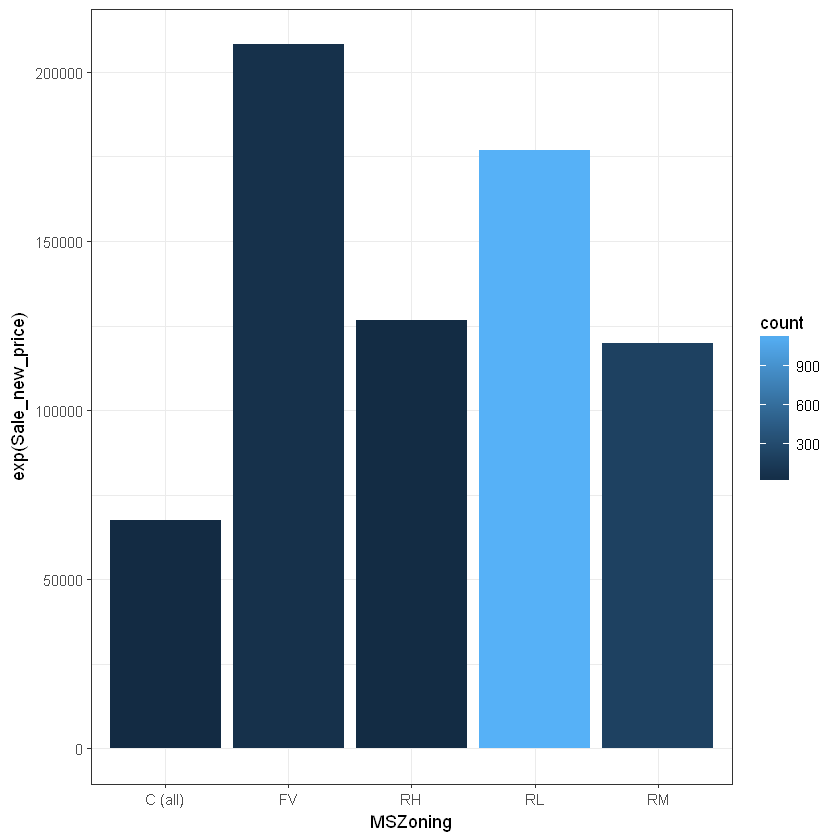

In [47]:
train_mz <- com_fin[com_fin$set == "train",] %>% group_by(MSZoning)  %>% summarize(Sale_new_price = mean(SalePrice), count = n())
train_mz
ggplot(train_mz, aes(x = MSZoning, y = exp(Sale_new_price), fill = count)) + geom_col() + theme_bw()

Another evident divide means anothe regrouping!

In [48]:
High_end_zone <- unlist(unclass(train_mz %>% filter(Sale_new_price > log(175000)) %>% select(MSZoning)))
Mid_end_zone <- unlist(unclass(train_mz %>% filter(Sale_new_price < log(175000) & Sale_new_price > log(125000)) %>% select(MSZoning)))
low_end_zone <- unlist(unclass(train_mz %>% filter(Sale_new_price < log(125000)) %>% select(MSZoning)))

In [49]:
com_fin <- com_fin %>% mutate(zone_type = case_when(MSZoning %in% High_end_zone ~ "high",
                                                MSZoning %in% Mid_end_zone ~ "mid",
                                                MSZoning %in% low_end_zone ~ "low"))
com_fin$zone_type <- as.factor(com_fin$zone_type)

Now with the bath variable, there are a number of features in the orginal data that talks about the bath number. It should be strategic to combine them all instead of having the model use them as separate features

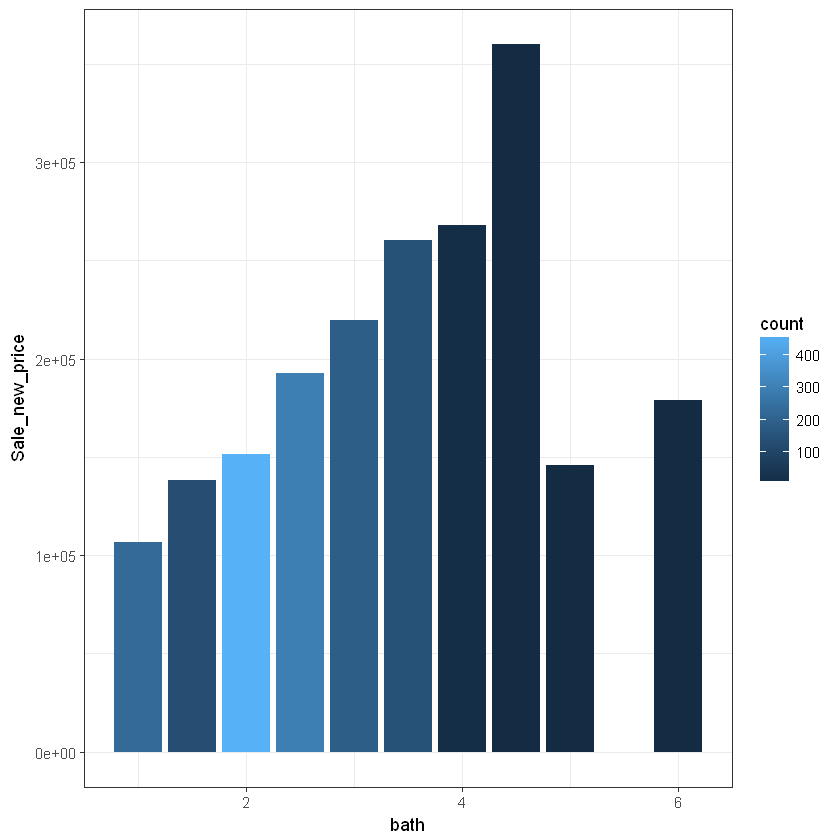

In [50]:
com_fin <- com_fin %>% mutate(bath = FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath)
train_ba <- com_fin[com_fin$set == "train",] %>% group_by(bath)  %>% summarize(Sale_new_price = exp(mean(SalePrice)), count = n())
ggplot(train_ba, aes(x = bath, y = Sale_new_price, fill = count)) + geom_col()+ theme_bw()

It is noticeable that in the rest of variables, a number of them describe a certain area of the house, so I arranged them into separate tables and plotted them out from there. The first category would the variables describing the lot of the house

   SalePrice      LotFrontage        LotArea       LotShape    LotConfig   
 Min.   :10.46   Min.   : 18.11   Min.   :  1300   IR1:481   Corner : 260  
 1st Qu.:11.77   1st Qu.: 59.00   1st Qu.:  7539   IR2: 41   CulDSac:  94  
 Median :12.00   Median : 70.00   Median :  9468   IR3:  9   FR2    :  47  
 Mean   :12.02   Mean   : 70.26   Mean   : 10449   Reg:925   FR3    :   4  
 3rd Qu.:12.27   3rd Qu.: 80.00   3rd Qu.: 11588             Inside :1051  
 Max.   :13.35   Max.   :313.00   Max.   :215245                           

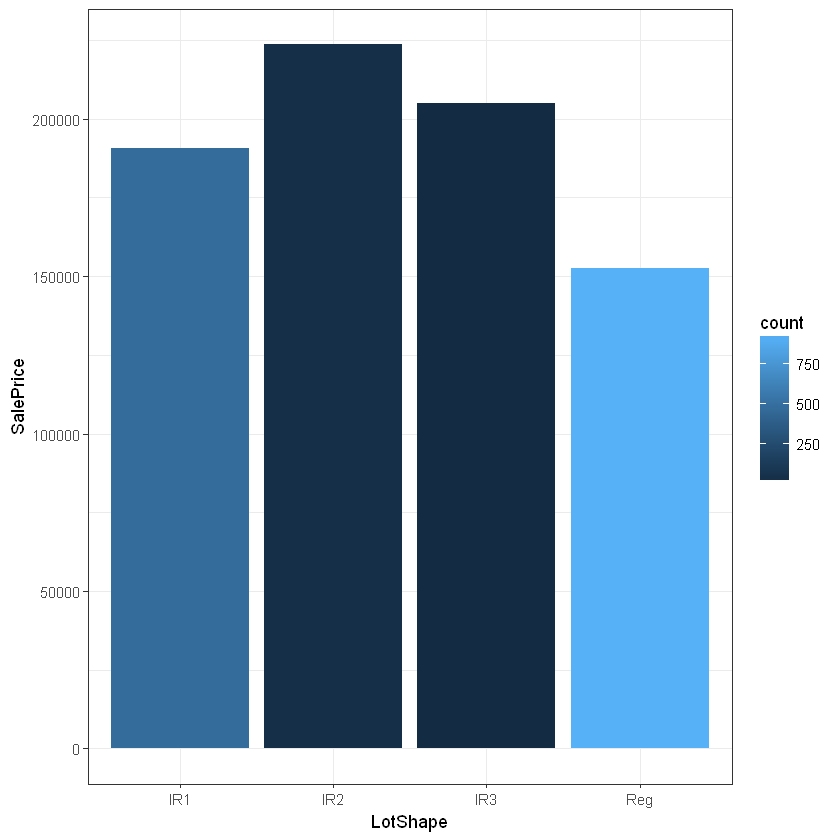

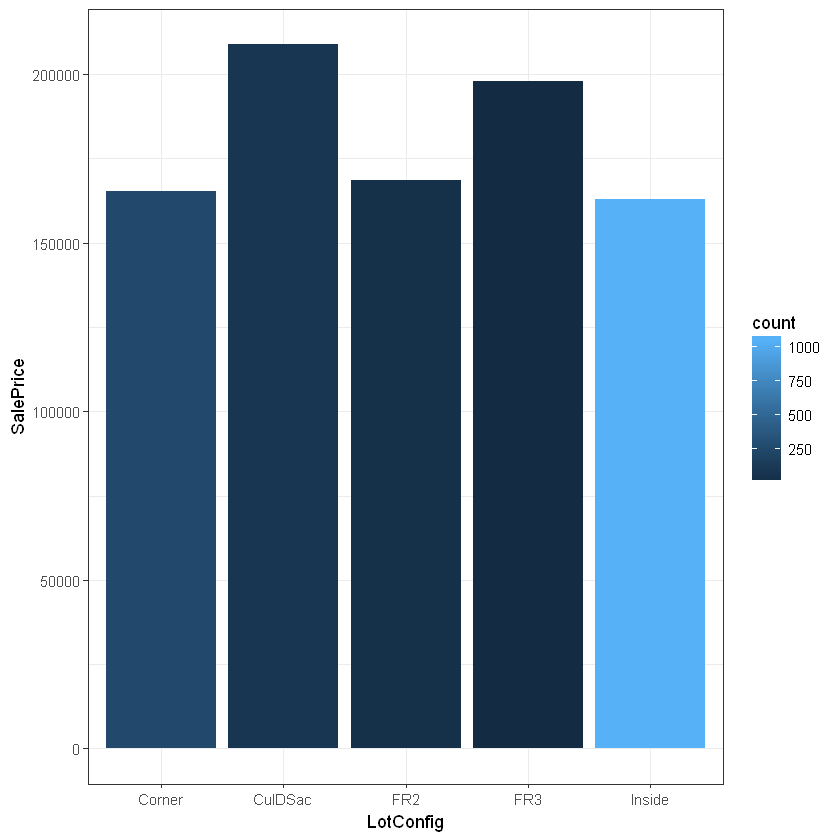

In [51]:
lot_table <- com_fin[com_fin$set == "train",][,c(65 ,grep("Lot", names(com_fin[com_fin$set == "train",])))]
summary(lot_table)
ggplot(lot_table %>% group_by(LotShape) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=LotShape, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(lot_table %>% group_by(LotConfig) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=LotConfig, y=SalePrice, fill = count)) + geom_col()+ theme_bw()

Both Lot Config and Lot Shape could use some cleaning and condensing so let us get to it

In [52]:
com_fin <- com_fin %>% mutate(lshape = case_when(LotShape %in% c("Reg") ~ "low",
                                                LotShape %in% c("IR1","IR3") ~ "mid_low",
                                                LotShape %in% c("IR2") ~ "high"))
com_fin <- com_fin %>% mutate(lconfig = case_when(LotConfig %in% c("Corner", "FR2","Inside") ~ "low",
                                                LotConfig %in% c("CulDSac", "FR3") ~ "high"))
com_fin$lshape <- as.factor(com_fin$lshape)
com_fin$lconfig <- as.factor(com_fin$lconfig)

Another Category to look at are the variables describing the garage 

   SalePrice         GarageType   GarageYrBlt        GarageFinish
 Min.   :10.46   2Types   :  6   Min.   :  3.00   Fin      :348  
 1st Qu.:11.77   Attchd   :867   1st Qu.: 54.00   No_Garage: 81  
 Median :12.00   Basment  : 19   Median : 76.00   RFn      :422  
 Mean   :12.02   BuiltIn  : 87   Mean   : 72.42   Unf      :605  
 3rd Qu.:12.27   CarPort  :  9   3rd Qu.: 95.00                  
 Max.   :13.35   Detchd   :387   Max.   :104.00                  
                 No_Garage: 81                                   
   GarageCars      GarageArea    
 Min.   :0.000   Min.   :   0.0  
 1st Qu.:1.000   1st Qu.: 329.5  
 Median :2.000   Median : 478.5  
 Mean   :1.764   Mean   : 471.6  
 3rd Qu.:2.000   3rd Qu.: 576.0  
 Max.   :4.000   Max.   :1390.0  
                                 

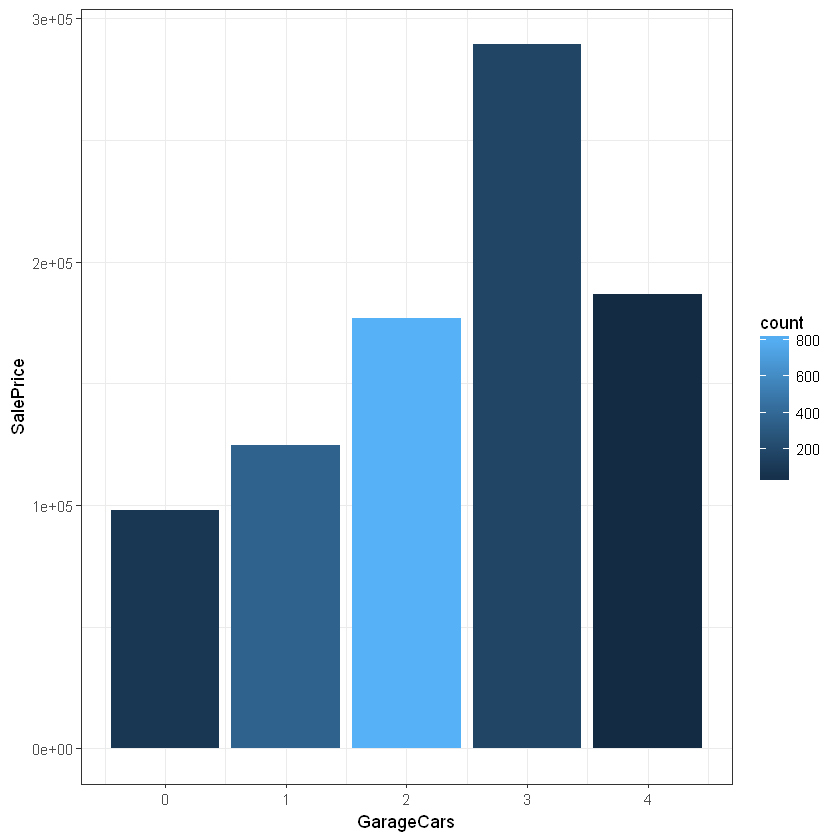

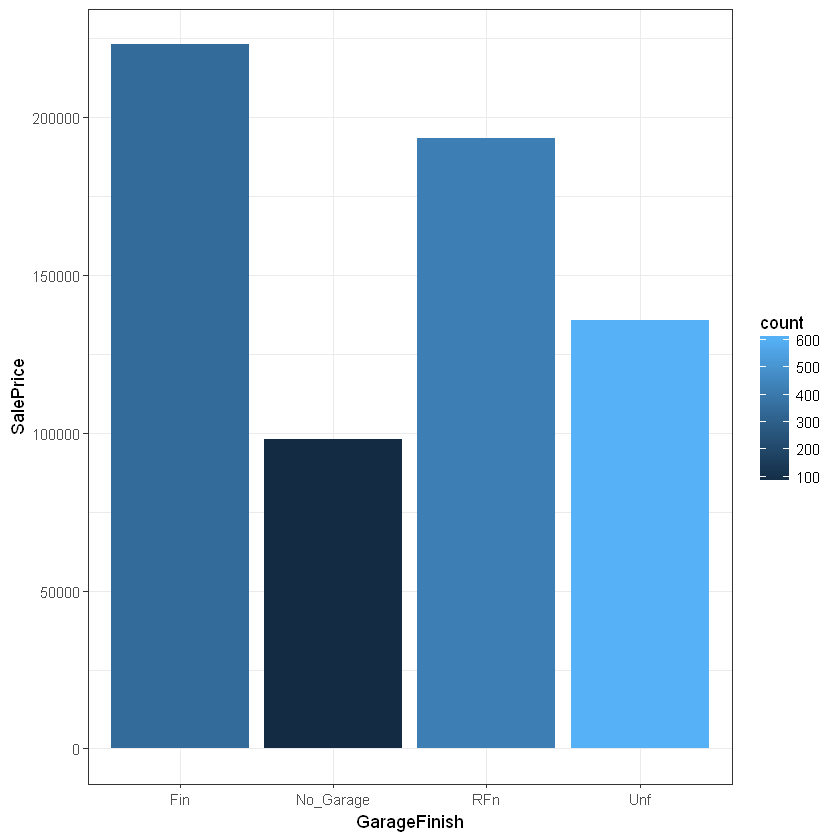

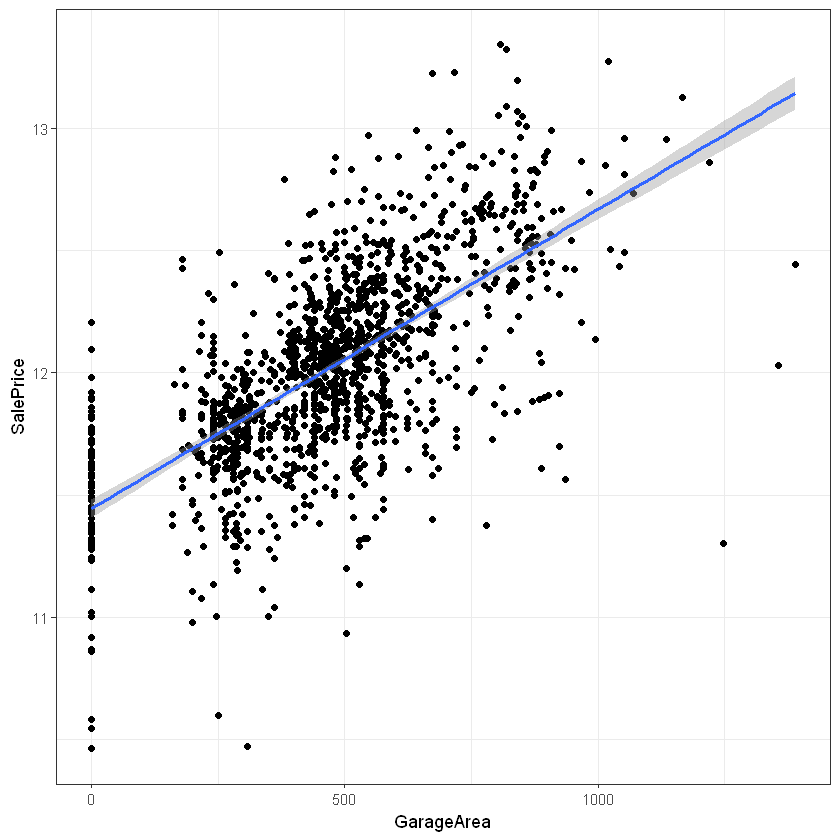

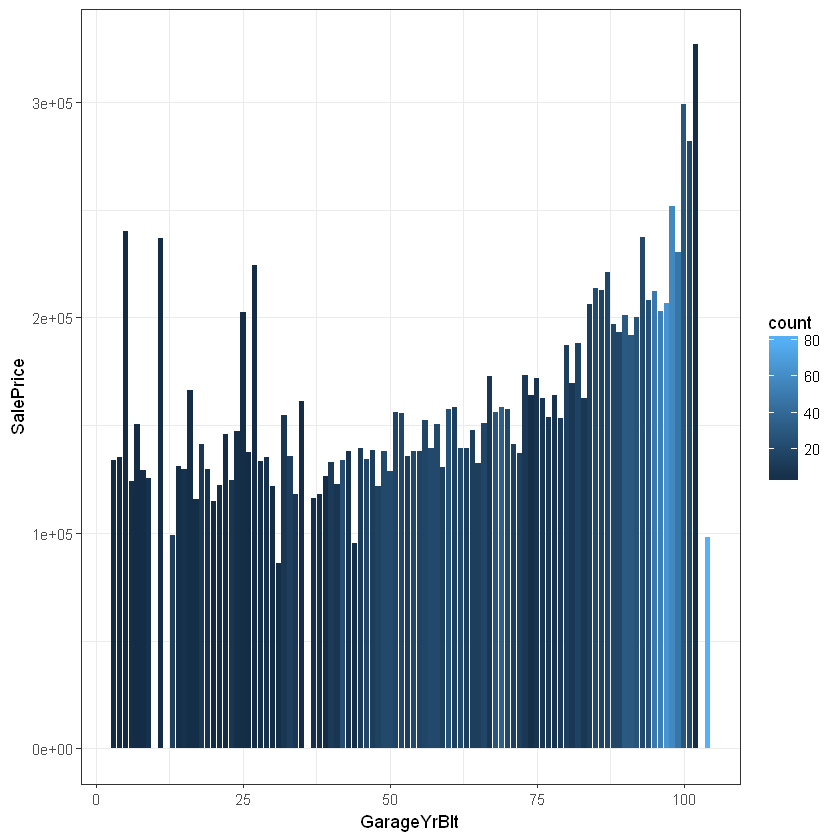

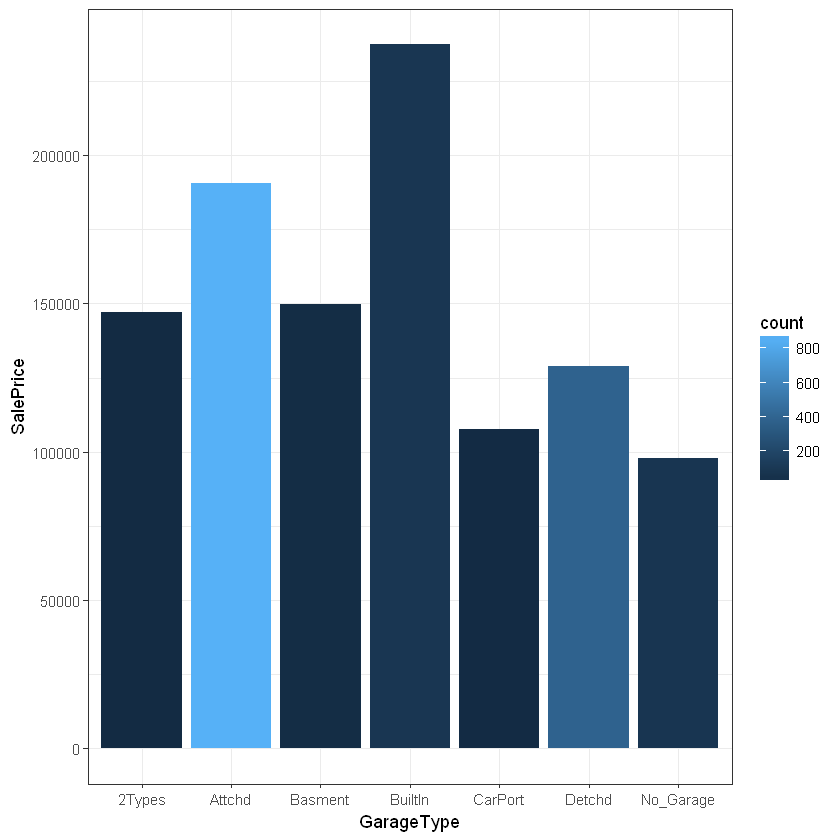

In [53]:
garage_table <- com_fin[com_fin$set == "train",][,c(65,grep("Garage", names(com_fin[com_fin$set == "train",])))]
summary(garage_table)
ggplot(garage_table %>% group_by(GarageCars) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=GarageCars, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(garage_table %>% group_by(GarageFinish) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=GarageFinish, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(garage_table, aes(x=GarageArea, y=SalePrice)) + geom_point()+ geom_smooth(method = "lm") + theme_bw()
ggplot(garage_table %>% group_by(GarageYrBlt) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=GarageYrBlt, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(garage_table %>% group_by(GarageType) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=GarageType, y=SalePrice, fill = count)) + geom_col()+ theme_bw()

let's clean and condense the data once again, and for the year data we will use a similar strategy used on the YearBuilt variable

In [54]:
com_fin <- com_fin %>% mutate(cars_type = case_when(GarageCars %in% c("0") ~ "low",
                                                GarageCars %in% c("1","1.05592543275632") ~ "mid_low",
                                                GarageCars %in% c("3") ~ "high",
                                                   GarageCars %in% c("2", "4", "5") ~ "mid"))
com_fin <- com_fin %>% mutate(gar_type = case_when(GarageType %in% c("CarPort", "No_Garage") ~ "low",
                                                GarageType %in% c("2Types", "Basment", "Detchd") ~ "mid_low",
                                                GarageType %in% c("BuiltIn") ~ "high",
                                                   GarageType %in% c( "Attchd") ~ "mid"))
com_fin <- com_fin %>% mutate(gar_age = case_when(GarageYrBlt <= 42 ~ "low",
                                                GarageYrBlt > 42 && GarageYrBlt <= 73 ~ "mid_low",
                                                GarageYrBlt > 73 && GarageYrBlt <= 86 ~ "mid",
                                                   GarageYrBlt > 86 ~ "high"))
com_fin$cars_type <- as.factor(com_fin$cars_type)
com_fin$gar_type <- as.factor(com_fin$gar_type)
com_fin$gar_age <- as.factor(com_fin$gar_age)

Now let us look at the Basement category and perform another round of cleaning

   SalePrice            BsmtQual          BsmtCond         BsmtExposure
 Min.   :10.46   Ex         :117   Fa         :  45   Av         :220  
 1st Qu.:11.77   Fa         : 35   Gd         :  65   Gd         :131  
 Median :12.00   Gd         :618   No_Basement:  37   Mn         :114  
 Mean   :12.02   No_Basement: 37   Po         :   2   No         :953  
 3rd Qu.:12.27   TA         :649   TA         :1307   No_Basement: 38  
 Max.   :13.35                                                         
                                                                       
      BsmtFinType1   BsmtFinSF1       BsmtUnfSF       TotalBsmtSF    
 ALQ        :220   Min.   :   0.0   Min.   :   0.0   Min.   :   0.0  
 BLQ        :148   1st Qu.:   0.0   1st Qu.: 222.5   1st Qu.: 795.0  
 GLQ        :414   Median : 381.0   Median : 477.5   Median : 990.5  
 LwQ        : 74   Mean   : 437.0   Mean   : 567.0   Mean   :1050.7  
 No_Basement: 37   3rd Qu.: 706.5   3rd Qu.: 808.0   3rd Qu.:1293.8  
 Rec

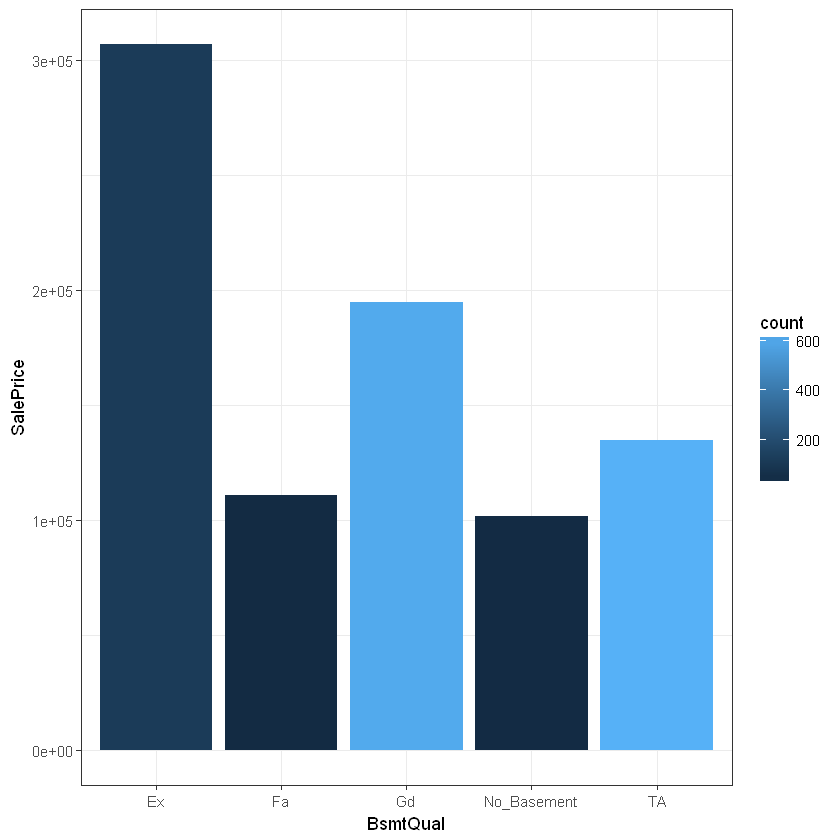

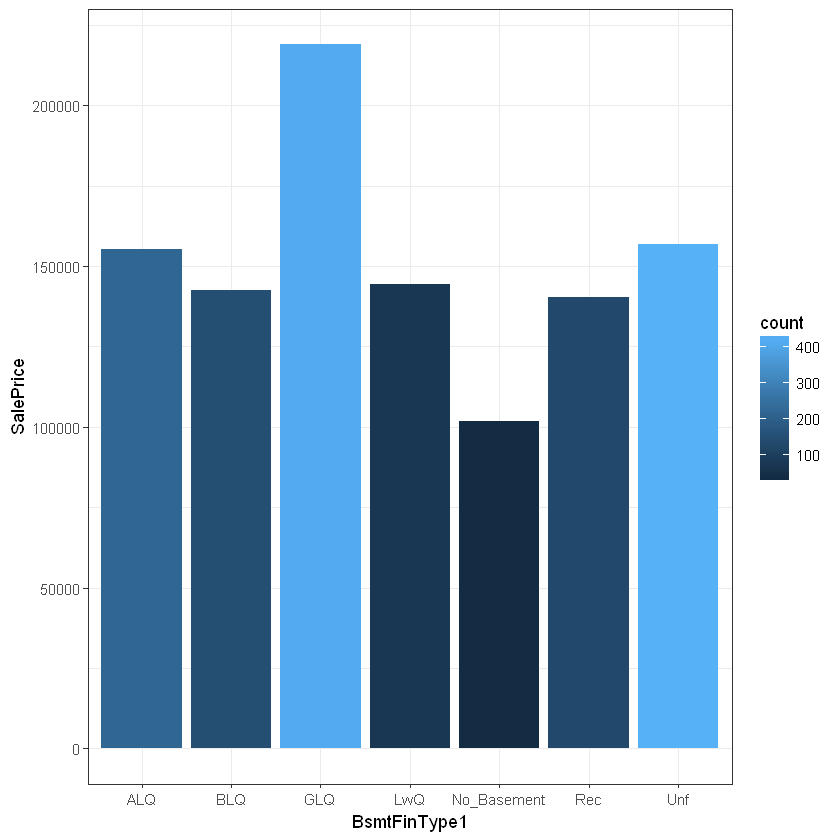

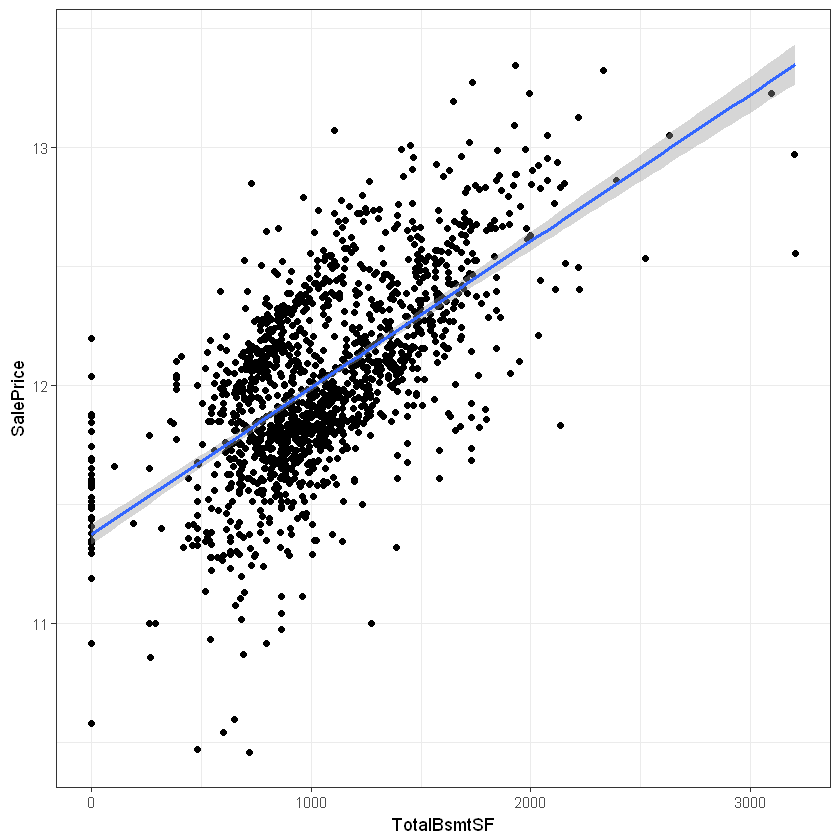

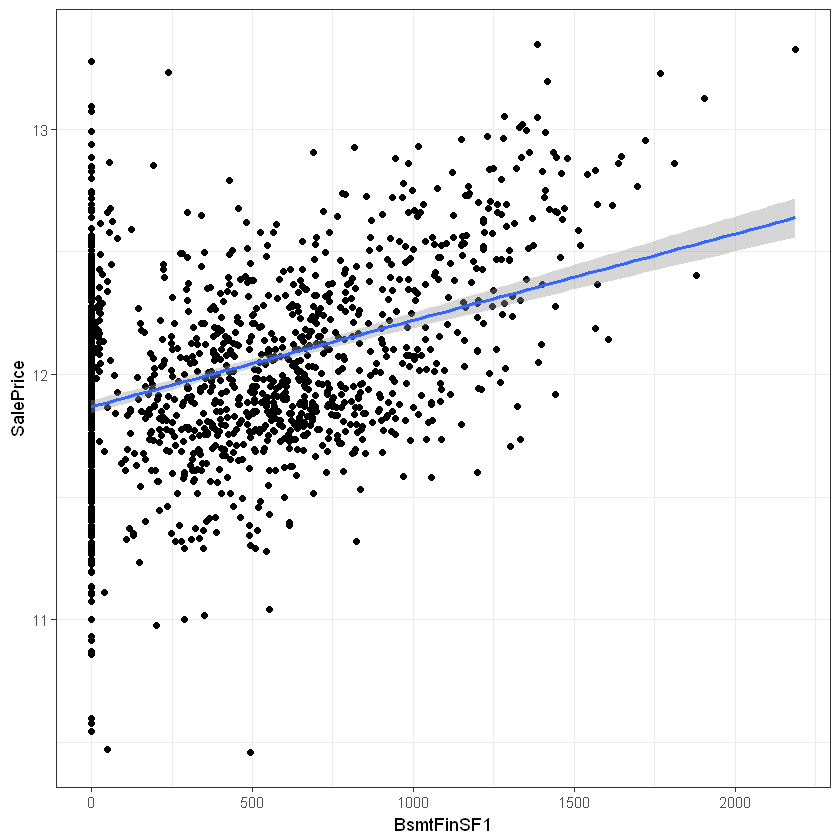

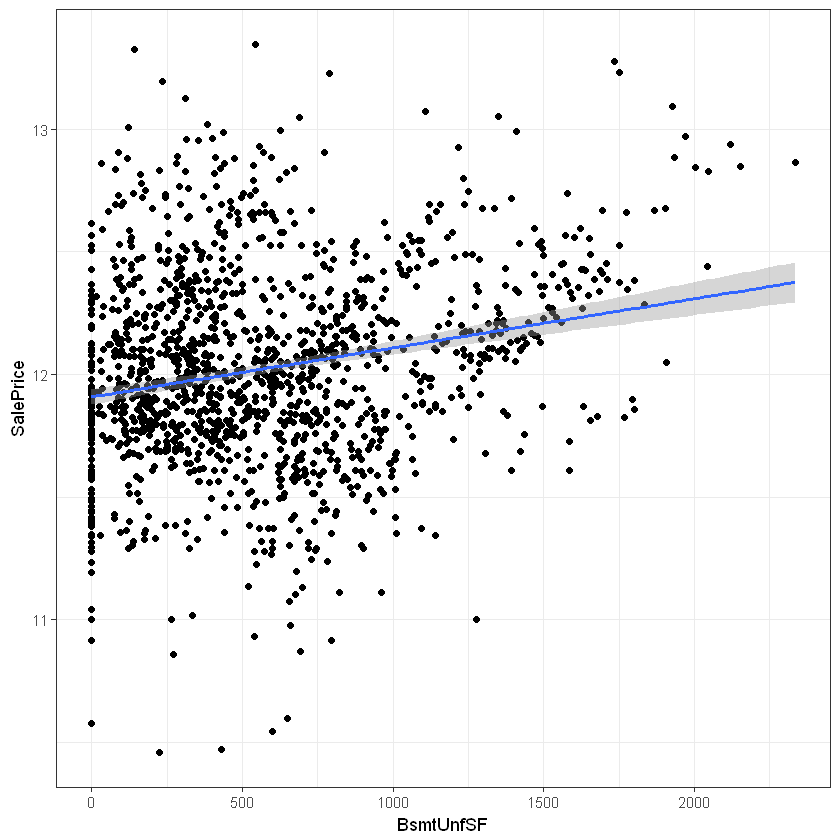

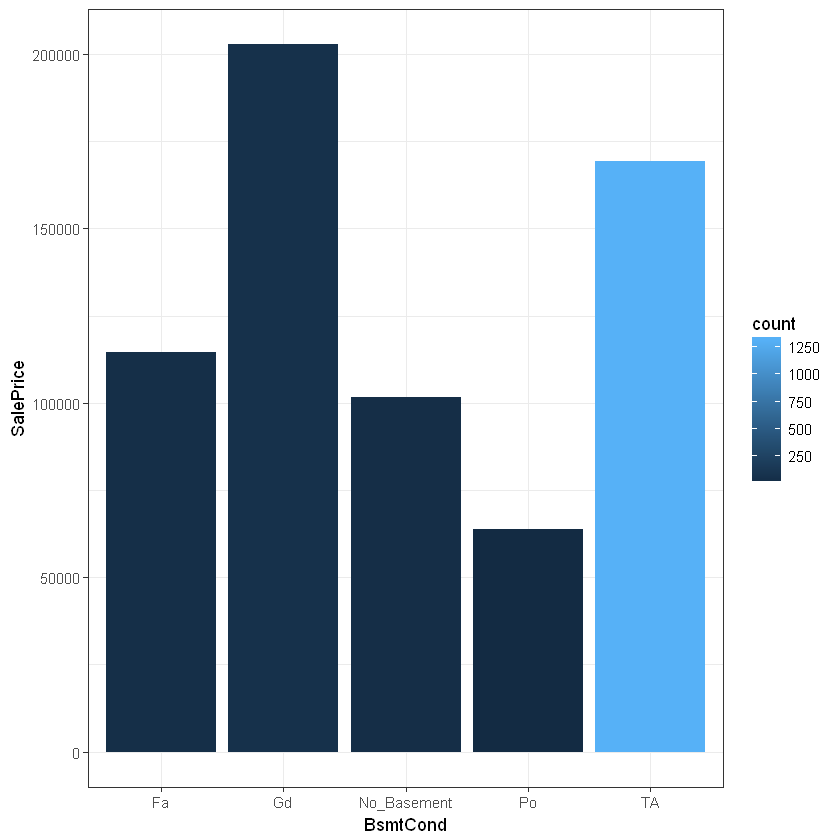

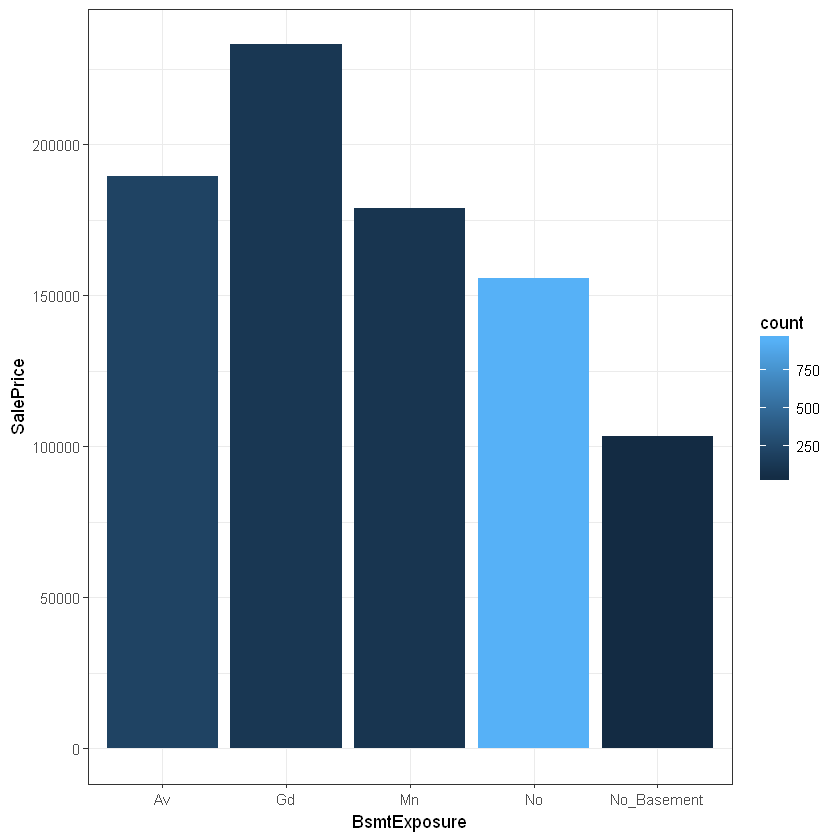

In [55]:
bsmt_table <- com_fin[com_fin$set == "train",][,c(65,grep("Bsmt", names(com_fin[com_fin$set == "train",])))]
summary(bsmt_table)
ggplot(bsmt_table %>% group_by(BsmtQual) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=BsmtQual, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(bsmt_table %>% group_by(BsmtFinType1) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=BsmtFinType1, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(bsmt_table, aes(x=TotalBsmtSF, y=SalePrice)) + geom_point()+ geom_smooth(method = "lm") + theme_bw()
ggplot(bsmt_table, aes(x=BsmtFinSF1, y=SalePrice)) + geom_point()+ geom_smooth(method = "lm") + theme_bw()
ggplot(bsmt_table, aes(x=BsmtUnfSF, y=SalePrice)) + geom_point()+ geom_smooth(method = "lm") + theme_bw()
ggplot(bsmt_table %>% group_by(BsmtCond) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=BsmtCond, y=SalePrice, fill = count)) + geom_col()+ theme_bw()
ggplot(bsmt_table %>% group_by(BsmtExposure) %>% summarize(SalePrice = exp(mean(SalePrice)), count = n()), aes(x=BsmtExposure, y=SalePrice, fill = count)) + geom_col()+ theme_bw()

In [56]:
com_fin <- com_fin %>% mutate(bsmt_type = case_when(BsmtFinType1 %in% c("No_Basement") ~ "low",
                                                BsmtFinType1 %in% c("GLQ") ~ "high",
                                                   TRUE ~ "mid"))
com_fin <- com_fin %>% mutate(bsmt_qual = case_when(BsmtQual %in% c("Gd") ~ "mid",
                                                BsmtQual %in% c("Ex") ~ "high",
                                                   TRUE ~ "low"))
com_fin <- com_fin %>% mutate(bsmt_cond = case_when(BsmtCond %in% c("TA") ~ "mid",
                                                BsmtCond %in% c("Ex", "Gd") ~ "high",
                                                   TRUE ~ "low"))
com_fin <- com_fin %>% mutate(bsmt_expo = case_when(BsmtExposure %in% c("No_Basement") ~ "low",
                                                BsmtExposure %in% c("Gd") ~ "high",
                                                   TRUE ~ "mid"))
com_fin$bsmt_type <- as.factor(com_fin$bsmt_type)
com_fin$bsmt_qual <- as.factor(com_fin$bsmt_qual)
com_fin$bsmt_cond <- as.factor(com_fin$bsmt_cond)
com_fin$bsmt_expo <- as.factor(com_fin$bsmt_expo)

## Machine Learning

Now to the machine learning portion, before applying any model, it is crucial that we first divide the set back to its origial training and testing set. More so we also need to divide the training set to a smaller training set and a validation set

In [57]:
com_fin$GarageYrBlt <- as.numeric(com_fin$GarageYrBlt)
train_re <- com_fin %>% filter(set == "train")
n <- nrow(train_re)
train_rand <- train_re[sample(1 : n),] 
i <- 3/4 * n
train_train <- train_rand[1 : i, ]
train_test <- train_rand[(i + 1) : n, ]

We will be employing a weighted model composed of Lasso, GBM and Xgboost. All the models are hypertuned to achieve optimal accuracy

In [58]:
set.seed(11)
tree11 <- train(SalePrice ~. - Neighborhood - MSSubClass - YearBuilt - FireplaceQu - FullBath - HalfBath - MSZoning - Id - BsmtFullBath - BsmtHalfBath - X1stFlrSF - X2ndFlrSF 
                - LotShape - LotConfig - GarageCars - GarageType - GarageYrBlt - BsmtFinType1 - BsmtQual - BsmtCond - BsmtExposure, 
                      data = train_train, method = "gbm", trControl = trainControl(method = "repeatedcv"),
                    tuneGrid = data.frame(interaction.depth = c(3), n.trees = c(250), shrinkage = c(0.1), n.minobsinnode = c(10)))
tree11
tree11$finalModel
pred_5 <- predict(tree11, train_test)
rmse(pred_5, train_test$SalePrice)

Loading required package: gbm
Loading required package: survival

Attaching package: 'survival'

The following object is masked from 'package:caret':

    cluster

Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3
Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 80, 70, 24, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 80, 70, 24, :
"variable 39: RoofMatlMembran has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 80, 70, 24, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 80, 70, 24, :
"variable 42: Exterior1stAsphShn has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 80, 70, 24, :
"variable 45: Exterior1stCBlock has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 80, 70, 24, :
"variable

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1333             nan     0.1000    0.0174
     2        0.1174             nan     0.1000    0.0134
     3        0.1053             nan     0.1000    0.0127
     4        0.0943             nan     0.1000    0.0111
     5        0.0841             nan     0.1000    0.0089
     6        0.0765             nan     0.1000    0.0077
     7        0.0694             nan     0.1000    0.0063
     8        0.0637             nan     0.1000    0.0059
     9        0.0590             nan     0.1000    0.0048
    10        0.0542             nan     0.1000    0.0045
    20        0.0281             nan     0.1000    0.0013
    40        0.0150             nan     0.1000    0.0002
    60        0.0118             nan     0.1000    0.0000
    80        0.0105             nan     0.1000    0.0000
   100        0.0096             nan     0.1000    0.0000
   120        0.0089             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1307             nan     0.1000    0.0182
     2        0.1160             nan     0.1000    0.0139
     3        0.1032             nan     0.1000    0.0118
     4        0.0920             nan     0.1000    0.0105
     5        0.0830             nan     0.1000    0.0081
     6        0.0754             nan     0.1000    0.0072
     7        0.0687             nan     0.1000    0.0061
     8        0.0626             nan     0.1000    0.0054
     9        0.0569             nan     0.1000    0.0052
    10        0.0525             nan     0.1000    0.0041
    20        0.0277             nan     0.1000    0.0013
    40        0.0151             nan     0.1000    0.0002
    60        0.0116             nan     0.1000    0.0000
    80        0.0101             nan     0.1000   -0.0000
   100        0.0093             nan     0.1000   -0.0000
   120        0.0086             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 43: Exterior1stBrkComm has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 92: HeatingQCPo has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1314             nan     0.1000    0.0170
     2        0.1162             nan     0.1000    0.0147
     3        0.1040             nan     0.1000    0.0125
     4        0.0929             nan     0.1000    0.0105
     5        0.0839             nan     0.1000    0.0087
     6        0.0757             nan     0.1000    0.0073
     7        0.0687             nan     0.1000    0.0060
     8        0.0630             nan     0.1000    0.0053
     9        0.0581             nan     0.1000    0.0049
    10        0.0535             nan     0.1000    0.0038
    20        0.0284             nan     0.1000    0.0011
    40        0.0156             nan     0.1000    0.0002
    60        0.0120             nan     0.1000    0.0001
    80        0.0104             nan     0.1000   -0.0000
   100        0.0093             nan     0.1000   -0.0001
   120        0.0087             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 80: ExterCondPo has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1305             nan     0.1000    0.0190
     2        0.1160             nan     0.1000    0.0148
     3        0.1037             nan     0.1000    0.0119
     4        0.0928             nan     0.1000    0.0100
     5        0.0835             nan     0.1000    0.0087
     6        0.0756             nan     0.1000    0.0078
     7        0.0685             nan     0.1000    0.0061
     8        0.0627             nan     0.1000    0.0051
     9        0.0577             nan     0.1000    0.0043
    10        0.0531             nan     0.1000    0.0041
    20        0.0276             nan     0.1000    0.0013
    40        0.0150             nan     0.1000    0.0002
    60        0.0119             nan     0.1000    0.0000
    80        0.0105             nan     0.1000   -0.0000
   100        0.0096             nan     0.1000   -0.0001
   120        0.0089             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 83.7129315058033, 80, 70, 40, 24, :
"variable 33: RoofStyleMansard has no variation."Warning message in gbm.fit(x = structure(c(80, 83.7129315058033, 80, 70, 40, 24, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 83.7129315058033, 80, 70, 40, 24, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 83.7129315058033, 80, 70, 40, 24, :
"variable 70: Exterior2ndOther has no variation."Warning message in gbm.fit(x = structure(c(80, 83.7129315058033, 80, 70, 40, 24, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 83.7129315058033, 80, 70, 40, 24, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1314             nan     0.1000    0.0175
     2        0.1165             nan     0.1000    0.0121
     3        0.1039             nan     0.1000    0.0129
     4        0.0931             nan     0.1000    0.0102
     5        0.0845             nan     0.1000    0.0081
     6        0.0769             nan     0.1000    0.0075
     7        0.0700             nan     0.1000    0.0063
     8        0.0639             nan     0.1000    0.0052
     9        0.0582             nan     0.1000    0.0054
    10        0.0537             nan     0.1000    0.0045
    20        0.0287             nan     0.1000    0.0011
    40        0.0157             nan     0.1000    0.0002
    60        0.0124             nan     0.1000   -0.0000
    80        0.0106             nan     0.1000    0.0000
   100        0.0096             nan     0.1000   -0.0000
   120        0.0089             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1280             nan     0.1000    0.0169
     2        0.1141             nan     0.1000    0.0139
     3        0.1023             nan     0.1000    0.0128
     4        0.0921             nan     0.1000    0.0096
     5        0.0828             nan     0.1000    0.0089
     6        0.0742             nan     0.1000    0.0080
     7        0.0672             nan     0.1000    0.0061
     8        0.0613             nan     0.1000    0.0056
     9        0.0559             nan     0.1000    0.0050
    10        0.0515             nan     0.1000    0.0036
    20        0.0270             nan     0.1000    0.0011
    40        0.0144             nan     0.1000    0.0002
    60        0.0114             nan     0.1000    0.0000
    80        0.0099             nan     0.1000   -0.0000
   100        0.0089             nan     0.1000   -0.0000
   120        0.0082             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1343             nan     0.1000    0.0172
     2        0.1193             nan     0.1000    0.0153
     3        0.1063             nan     0.1000    0.0121
     4        0.0956             nan     0.1000    0.0103
     5        0.0863             nan     0.1000    0.0094
     6        0.0783             nan     0.1000    0.0074
     7        0.0711             nan     0.1000    0.0071
     8        0.0646             nan     0.1000    0.0055
     9        0.0592             nan     0.1000    0.0050
    10        0.0544             nan     0.1000    0.0045
    20        0.0282             nan     0.1000    0.0013
    40        0.0153             nan     0.1000    0.0002
    60        0.0119             nan     0.1000    0.0000
    80        0.0105             nan     0.1000   -0.0000
   100        0.0096             nan     0.1000   -0.0000
   120        0.0089             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 41: RoofMatlRoll has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1326             nan     0.1000    0.0176
     2        0.1179             nan     0.1000    0.0141
     3        0.1054             nan     0.1000    0.0127
     4        0.0947             nan     0.1000    0.0099
     5        0.0852             nan     0.1000    0.0090
     6        0.0776             nan     0.1000    0.0076
     7        0.0704             nan     0.1000    0.0067
     8        0.0642             nan     0.1000    0.0058
     9        0.0591             nan     0.1000    0.0049
    10        0.0544             nan     0.1000    0.0045
    20        0.0281             nan     0.1000    0.0013
    40        0.0154             nan     0.1000    0.0003
    60        0.0120             nan     0.1000    0.0001
    80        0.0105             nan     0.1000   -0.0000
   100        0.0096             nan     0.1000   -0.0000
   120        0.0089             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 99: ElectricalSBrKr has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1326             nan     0.1000    0.0170
     2        0.1168             nan     0.1000    0.0143
     3        0.1042             nan     0.1000    0.0125
     4        0.0932             nan     0.1000    0.0119
     5        0.0843             nan     0.1000    0.0083
     6        0.0763             nan     0.1000    0.0076
     7        0.0696             nan     0.1000    0.0068
     8        0.0633             nan     0.1000    0.0059
     9        0.0583             nan     0.1000    0.0046
    10        0.0534             nan     0.1000    0.0045
    20        0.0278             nan     0.1000    0.0011
    40        0.0151             nan     0.1000    0.0002
    60        0.0118             nan     0.1000    0.0000
    80        0.0104             nan     0.1000    0.0000
   100        0.0095             nan     0.1000   -0.0000
   120        0.0088             nan     0.1000   -0.0001
   140        

Warning message in gbm.fit(x = structure(c(74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1315             nan     0.1000    0.0177
     2        0.1165             nan     0.1000    0.0150
     3        0.1040             nan     0.1000    0.0121
     4        0.0928             nan     0.1000    0.0110
     5        0.0841             nan     0.1000    0.0082
     6        0.0754             nan     0.1000    0.0081
     7        0.0690             nan     0.1000    0.0060
     8        0.0631             nan     0.1000    0.0058
     9        0.0580             nan     0.1000    0.0047
    10        0.0536             nan     0.1000    0.0034
    20        0.0278             nan     0.1000    0.0014
    40        0.0153             nan     0.1000    0.0003
    60        0.0121             nan     0.1000   -0.0000
    80        0.0106             nan     0.1000   -0.0000
   100        0.0095             nan     0.1000   -0.0000
   120        0.0088             nan     0.1000   -0.0000
   140        

Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 38: RoofMatlClyTile has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 40: RoofMatlMetal has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 97: ElectricalMix has no variation."Warning message in gbm.fit(x = structure(c(80, 74.9075335280408, 70, 83.7129315058033, :
"variable 139: settrain has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.1318             nan     0.1000    0.0174
     2        0.1174             nan     0.1000    0.0139
     3        0.1044             nan     0.1000    0.0121
     4        0.0942             nan     0.1000    0.0095
     5        0.0856             nan     0.1000    0.0078
     6        0.0774             nan     0.1000    0.0075
     7        0.0700             nan     0.1000    0.0067
     8        0.0631             nan     0.1000    0.0062
     9        0.0581             nan     0.1000    0.0049
    10        0.0540             nan     0.1000    0.0034
    20        0.0281             nan     0.1000    0.0010
    40        0.0154             nan     0.1000    0.0002
    60        0.0121             nan     0.1000    0.0001
    80        0.0106             nan     0.1000   -0.0000
   100        0.0096             nan     0.1000   -0.0000
   120        0.0089             nan     0.1000   -0.0000
   140        

Stochastic Gradient Boosting 

1092 samples
  81 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 982, 983, 983, 981, 983, 984, ... 
Resampling results:

  RMSE       Rsquared 
  0.1163127  0.9097512

Tuning parameter 'n.trees' was held constant at a value of 250
Tuning

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10

A gradient boosted model with gaussian loss function.
250 iterations were performed.
There were 171 predictors of which 87 had non-zero influence.

[1] 0.1327674

In [59]:
tree11
tree11$finalModel
pred_5 <- predict(tree11, train_test)
rmse(pred_5, train_test$SalePrice)

Stochastic Gradient Boosting 

1092 samples
  81 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 982, 983, 983, 981, 983, 984, ... 
Resampling results:

  RMSE       Rsquared 
  0.1163127  0.9097512

Tuning parameter 'n.trees' was held constant at a value of 250
Tuning

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10

A gradient boosted model with gaussian loss function.
250 iterations were performed.
There were 171 predictors of which 87 had non-zero influence.

[1] 0.1327674

In [60]:
set.seed(11)
tree12 <- train(SalePrice ~. - Neighborhood - MSSubClass - YearBuilt - FireplaceQu - FullBath - HalfBath - MSZoning - Id - BsmtFullBath - BsmtHalfBath - X1stFlrSF - X2ndFlrSF 
                - LotShape - LotConfig - GarageCars - GarageType - GarageYrBlt - BsmtFinType1 - BsmtQual - BsmtCond - BsmtExposure, 
                      data = train_train, method = "glmnet", trControl = trainControl(method = "repeatedcv"),
                      tuneGrid = data.frame(alpha = c(0.65), lambda = c(0.0064)))
tree12
pred_6 <- predict(tree12, train_test)
rmse(pred_6, train_test$SalePrice)

glmnet 

1092 samples
  81 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 982, 983, 983, 981, 983, 984, ... 
Resampling results:

  RMSE       Rsquared 
  0.1139791  0.9145645

Tuning parameter 'alpha' was held constant at a value of 0.65
Tuning
 parameter 'lambda' was held constant at a value of 0.0064

[1] 0.1312

In [61]:
set.seed(11)
tree13 <- train(SalePrice ~. - Neighborhood - MSSubClass - YearBuilt - FireplaceQu - FullBath - HalfBath - MSZoning - Id - BsmtFullBath - BsmtHalfBath - X1stFlrSF - X2ndFlrSF 
                - LotShape - LotConfig - GarageCars - GarageType - GarageYrBlt - BsmtFinType1 - BsmtQual - BsmtCond - BsmtExposure, 
                      data = train_train, method = "xgbTree", trControl = trainControl(method = "repeatedcv"),
                       tuneGrid = data.frame(nrounds = c(300), max_depth = c(2), eta = c(0.1), gamma = c(0.01), colsample_bytree = c(0.5),
                                            min_child_weight = c(1), subsample = c(1)))
tree13
pred_7 <- predict(tree13, train_test)
rmse(pred_7, train_test$SalePrice)

eXtreme Gradient Boosting 

1092 samples
  81 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 982, 983, 983, 981, 983, 984, ... 
Resampling results:

  RMSE       Rsquared 
  0.1172232  0.9089366

Tuning parameter 'nrounds' was held constant at a value of 300
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1

[1] 0.1354369

In [62]:
rmse((0.3*pred_5 + 0.6*pred_6 + 0.1*pred_7),train_test$SalePrice)

[1] 0.1289189

In [63]:
test_re <- com_fin %>% filter(set == "test")
test_re[1359,]$SubClass_type = "mid"
test_re$SubClass_type = as.factor(test_re$SubClass_type)

In [64]:
pred2 <- exp(predict(tree11, test_re))
pred3 <- exp(predict(tree12, test_re))
pred5 <- exp(predict(tree13, test_re))
pred6 <- 0.3*pred2 + 0.6*pred3 + 0.1*pred5

In [65]:
submit1 <- data.frame(Id = test$Id, SalePrice = pred6, row.names = NULL)

In [66]:
write.csv(submit1, file = "sad13.csv", row.names = FALSE)

The accuracy seems quite good here, however it is expected for it to be lower in the actual submission: 0.12438. 

## Insight Extraction

We will be using a combination of random forest, partial dependence plot and rpart to extract a bit of insight regarding housing prices. First let's start with running a random Forest and checking the variable importance


Call:
 randomForest(formula = exp(SalePrice) ~ . - Neighborhood - MSSubClass -      YearBuilt - FireplaceQu - FullBath - HalfBath - MSZoning -      Id - BsmtFullBath - BsmtHalfBath - X1stFlrSF - X2ndFlrSF -      LotShape - LotConfig - GarageCars - GarageType - GarageYrBlt -      BsmtFinType1 - BsmtQual - BsmtCond - BsmtExposure, data = train_train) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 20

          Mean of squared residuals: 625789358
                    % Var explained: 89.31

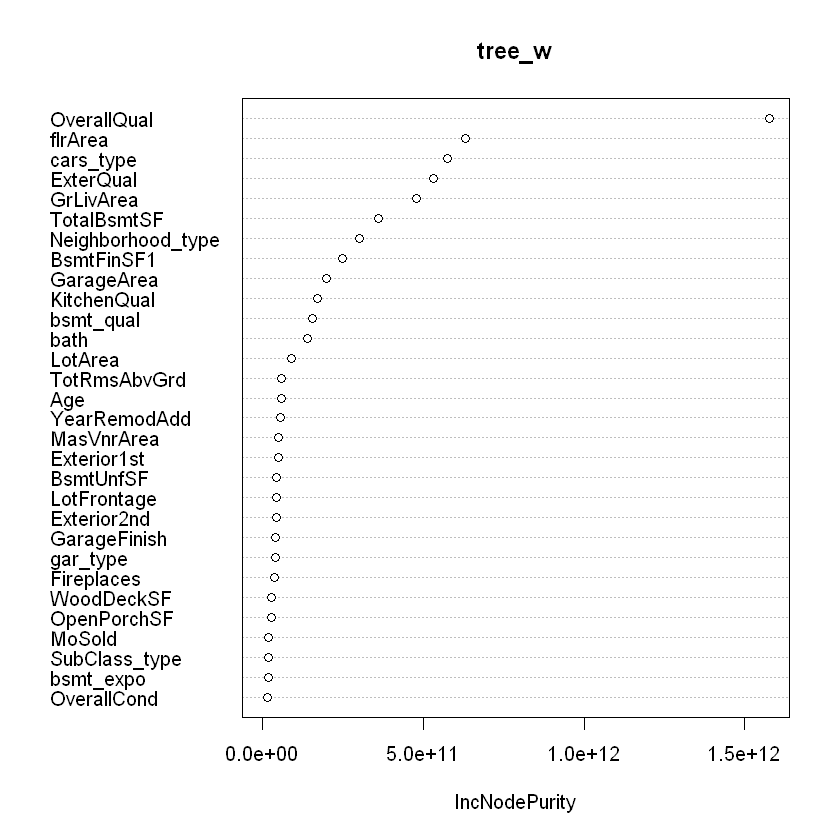

In [67]:
set.seed(010)
tree_w <- randomForest(exp(SalePrice) ~. - Neighborhood - MSSubClass - YearBuilt - FireplaceQu - FullBath - HalfBath - MSZoning - Id - BsmtFullBath - BsmtHalfBath - X1stFlrSF - X2ndFlrSF 
                - LotShape - LotConfig - GarageCars - GarageType - GarageYrBlt - BsmtFinType1 - BsmtQual - BsmtCond - BsmtExposure, data = train_train)
tree_w
varImpPlot(tree_w)

We seem to be right about how the overall quality and the area of the house are quite related to its price. There also seem to be a greater emphasize on the utilities of the house such as number of baths, quality of the kitchen, fireplaces and number of bedrooms than features that deal with style more such as house style and roof material. It is also important to note how neighborhood plays a great role in determining the price of the house. This may be due to the fact that some neighborhood are nearer to more resources like school, malls and the like.

In [68]:
train_train_mod <- subset(train_train, select = - c(Neighborhood, MSSubClass, YearBuilt, FireplaceQu, FullBath, HalfBath, MSZoning, Id, BsmtFullBath, BsmtHalfBath, X1stFlrSF, X2ndFlrSF, 
                LotShape, LotConfig, GarageCars, GarageType, GarageYrBlt, BsmtFinType1, BsmtQual, BsmtCond, BsmtExposure))
tree <- rpart(SalePrice ~., data = train_train_mod)
tree

n= 1092 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 1092 163.267200 12.02166  
   2) OverallQual< 6.5 692  49.482060 11.81809  
     4) flrArea< 1378.5 438  24.689370 11.71678  
       8) TotalBsmtSF< 790.5 137   8.526070 11.53274  
        16) GrLivArea< 1134.5 79   4.417763 11.42278 *
        17) GrLivArea>=1134.5 58   1.851769 11.68253 *
       9) TotalBsmtSF>=790.5 301   9.411356 11.80054  
        18) bath< 1.25 88   1.922367 11.66864 *
        19) bath>=1.25 213   5.325385 11.85504 *
     5) flrArea>=1378.5 254  12.545230 11.99279  
      10) Neighborhood_type=low,mid_low 161   7.028692 11.90036 *
      11) Neighborhood_type=mid 93   1.759999 12.15280 *
   3) OverallQual>=6.5 400  35.495410 12.37384  
     6) OverallQual< 7.5 238  10.997090 12.22637  
      12) GrLivArea< 1935 178   6.360568 12.16195 *
      13) GrLivArea>=1935 60   1.706170 12.41749 *
     7) OverallQual>=7.5 162  11.718180 12.59049  
      14) OverallQual< 8.5 119   6.004594 12.497

Running an rpart confirms most the variable that ranked on top of the variable importance plot earlier, another feature that was brought to our attention is the Central Air Unit, which would make sense given it is also an essential for a well equipped house. Next we'll run some partial dependence plot on some of the common and interesting features

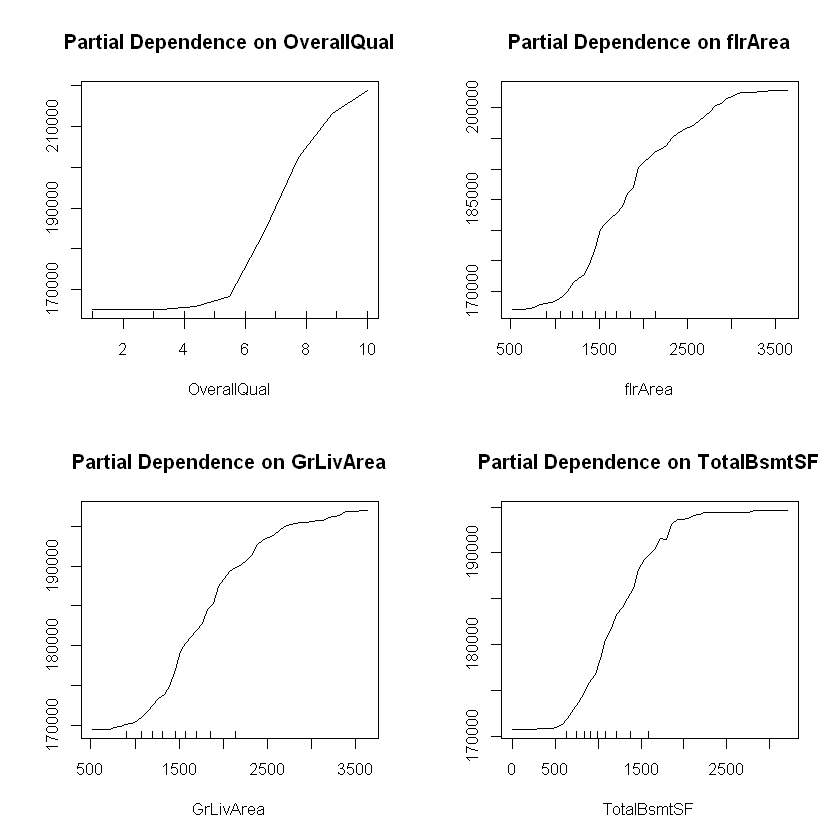

In [69]:
op <- par(mfrow = c(2,2))
partialPlot(tree_w, train_train, OverallQual)
partialPlot(tree_w, train_train, flrArea)
partialPlot(tree_w, train_train, GrLivArea)
partialPlot(tree_w, train_train, TotalBsmtSF)

The first series of features I selected are the top area features in the data set and it quite confirms our instinct that the bigger the house is the higher the price.

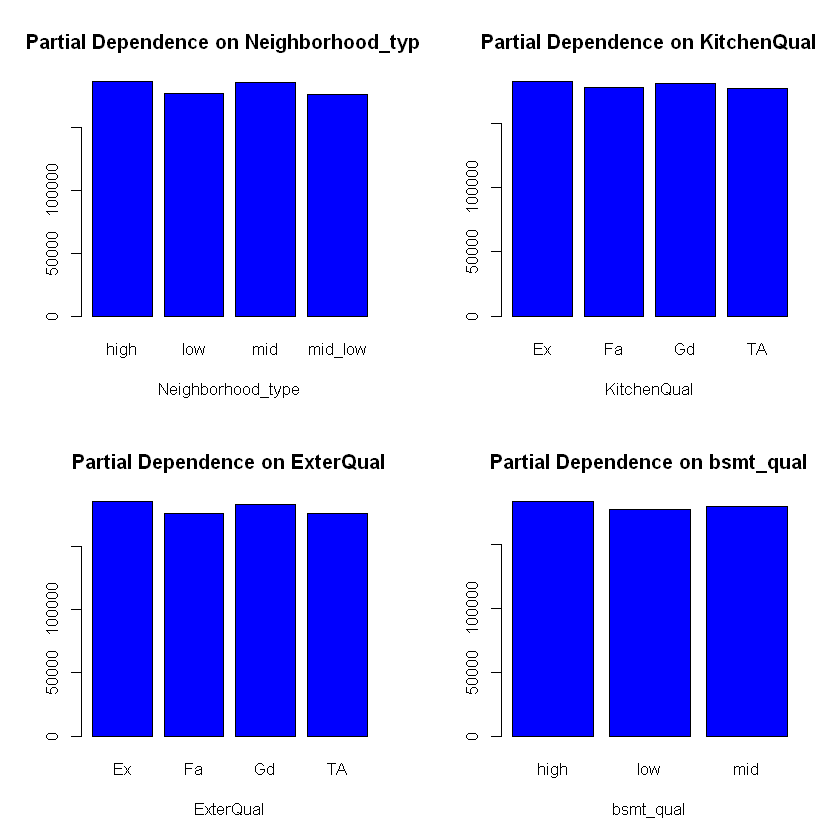

In [70]:
op <- par(mfrow = c(2,2))
partialPlot(tree_w, train_train, Neighborhood_type)
partialPlot(tree_w, train_train, KitchenQual)
partialPlot(tree_w, train_train, ExterQual)
partialPlot(tree_w, train_train, bsmt_qual)

Another affirmation is also quite a simple one, features that are ordered by their quality also show a positive correlation with price. Those with features marked as excellent and good tends to be higher price than those marked as poor.

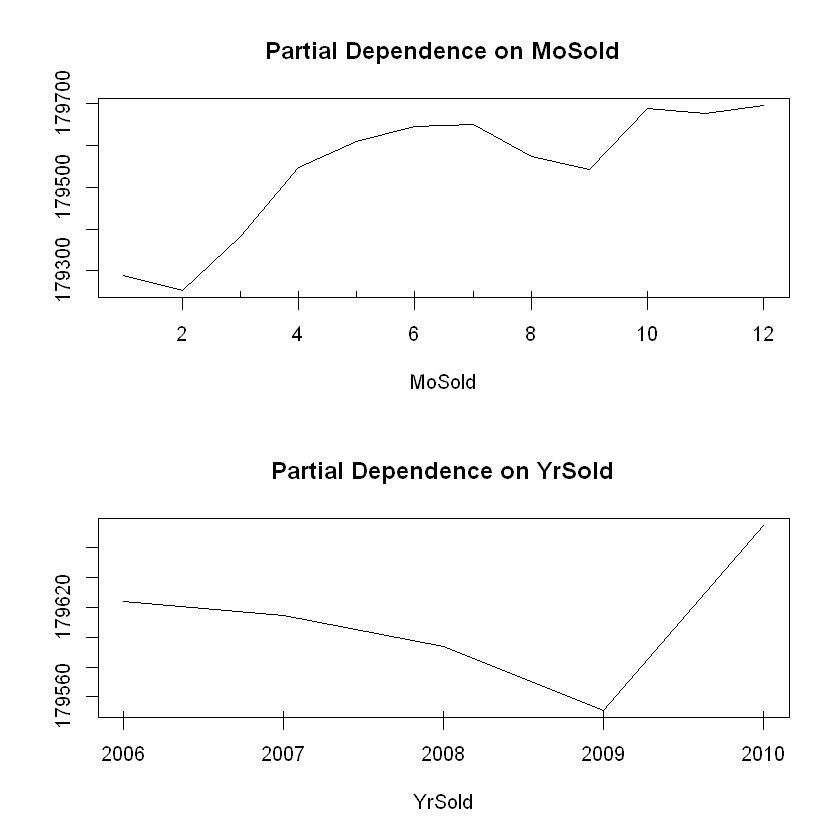

In [71]:
op <- par(mfrow = c(2,1))
partialPlot(tree_w, train_train, MoSold)
partialPlot(tree_w, train_train, YrSold)

An interesting feature to look at would be the influence of time on the price of the houses. in the above graph we can evidently see how seasonality greatly change prices of the house. People don't tend to buy houses in the beginning of the year, as opposed to the mid year and end year rush. The year in which the house is sold are also quite consistent with the historical background, particularly being that 2008 and 2009 is a time where housing bubble greatly bursted and the nation went through a financial crisis, causing housing prices to fall.

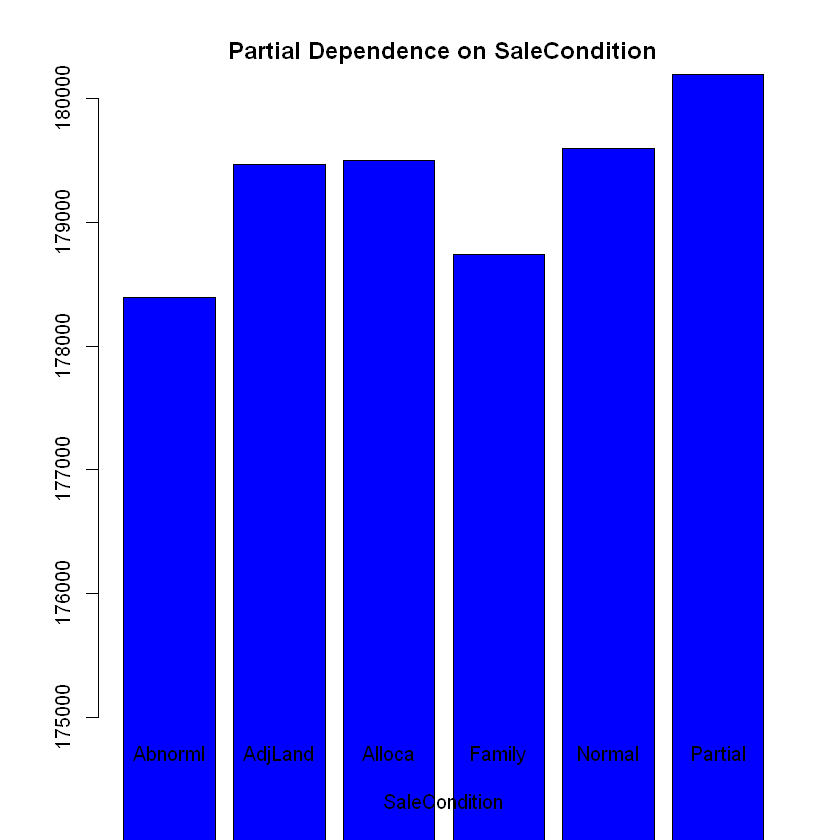

In [72]:
partialPlot(tree_w, train_train, SaleCondition, ylim = c(175000, 180000))

Another interesting feature is the way the houses are sold. From the above data we could see that when houses are sold by family is at a lower price compared to those sold in abnormal condition. Houses with allocation along with those that are quite new and unfinished are sold at a higher price than those in normal sell. Interesting!

This concludes this notebook, hopefully it is pretty helpful, feel free to hit me up with any concern or questions!